# Testing a model template

In [1]:
# Packages used for developing models, as well as processing information

from IPython import get_ipython
from IPython.display import display
# %%
from sklearn.svm import SVC
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from warnings import filterwarnings
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score,f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB

import csv


filterwarnings('ignore')

#Class Processing Data

In [7]:
class processing_data:
  def __init__(self,base,label='Processing Dataset'):
    self.base = base
    self.label = label
    self.min_max_scaler = MinMaxScaler()


  def float_values(self, X, str_var):
        for column in str_var:
                try:
                    # Attempt to convert the column to float
                    # If the column is not already of type object (string),
                    # convert it first before applying string operations.
                    X[column] = X[column].astype(str).str.replace(',', '.').astype(float) # Use X instead of self.base
                except ValueError:
                    # If conversion fails, print a message and skip the column
                    print(f"Column '{column}' could not be converted to float. Skipping...")

        return X


  def int_values(self, X, str_var):
        for column in str_var:
                try:
                    # Attempt to convert the column to int
                    #X[column] = X[column].astype(int)
                    X[column]=pd.to_numeric(X[column], errors='coerce').astype(int) #changed column to X[column]
                except ValueError:
                    # If conversion fails, print a message and skip the column
                    print(f"Column '{column}' could not be converted to int. Skipping...")

        return X


  #if my target is a text I transform in dummy value
  #def target_variable(self,X,variavel):
  #  keys = list(self.base[variavel].unique())
  #  my_dict = {}

 #   for i, key in enumerate(keys):
 #     my_dict[key] = i
 #   self.base[variavel] = self.base[variavel].map(my_dict)
 #   return self.base,my_dict

  def target_variable(self,X,variavel,target, multiclass):
    if multiclass == False:
      self.base[variavel] = np.where(self.base[variavel]==target, 1, 0)
      return self.base
    else:
      keys = list(self.base[variavel].unique())
      my_dict = {}

      for i, key in enumerate(keys):
       my_dict[key] = i
      self.base[variavel] = self.base[variavel].map(my_dict)
      #with open('list_variables_markers.txt', 'w') as file:
      # file.write(my_dict)

      # open file for writing, "w" is writing
      w = csv.writer(open("output.csv", "w"))
      # loop over dictionary keys and values
      for key, val in my_dict.items():
      # write every key and value to file
        w.writerow([key, val])
      return self.base


  # transform in dummies some variables
  def dummy_df(self,X,dummies):
      X = pd.get_dummies(X, prefix=dummies, columns=dummies,dtype='int')
      return X

  def normalize_df(self,X,variavel):
    #Normalize the data
    column_to_move = X.pop(variavel)
    X[variavel] = column_to_move

    Lista_variaveis = X.columns[:-1]
    X=X.iloc[:,:-1]
    y=column_to_move.values
    X =pd.DataFrame(data=X, columns=Lista_variaveis)
    min_max_scaler =MinMaxScaler()
    X = self.min_max_scaler.fit_transform(X)
    return X,y,Lista_variaveis

  def impute_values(self, X, type_method):
        # Get the indices of columns with missing values within the impute_values method
        missing_cols_indices = [i for i, col in enumerate(X.columns) if X[col].isnull().any()]
        imputer = SimpleImputer(missing_values=np.nan, strategy=type_method)
        X_df = pd.DataFrame(X, columns = X.columns) # Use X.columns to ensure all columns are included

        # Impute missing values using these indices
        if missing_cols_indices:  # Check if there are any missing columns
            # Reshape the output of fit_transform to match the number of columns
            imputed_data = imputer.fit_transform(X_df[X_df.columns[missing_cols_indices]])
            # Create a DataFrame with the imputed values and correct columns
            #Instead of using X_df.columns[missing_cols_indices] I use X_df.columns[missing_cols_indices].to_list() for creating the dataframe
            imputed_df = pd.DataFrame(imputed_data, columns=X_df.columns[missing_cols_indices].to_list(), index=X_df.index) # Changed this line
            # Update the original DataFrame with the imputed values
            X_df.update(imputed_df)

        return X_df

#Class Models

In [64]:
class models_types:
  def __init__(self,X,y,Lista_variaveis,batch_size=None,epochs=None,cluster=None,model_tree=None):
    self.X = X
    self.y = y
    self.Lista_variaveis = Lista_variaveis
    self.batch_size = batch_size
    self.epochs = epochs
    self.cluster = cluster
    self.model_tree = model_tree
    self.min_max_scaler = MinMaxScaler()
    self.l_encode = LabelEncoder()
    self.l_encode.fit(np.unique(y))

  #Neural Network Model
  def neuro_model(self):
    num_neu= len(self.Lista_variaveis)
    targ=2
    ocult_neu=int((num_neu*(2/3))+2)

    neuro=tf.keras.models.Sequential([tf.keras.layers.Dense(num_neu,input_shape=(len(self.Lista_variaveis),)
                                                  ,activation='relu',kernel_initializer='he_normal'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(ocult_neu,activation='relu',kernel_initializer='he_normal'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(2, activation='softmax')])
    #Train setings
    neuro.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(), #or binary_crossentropy
                metrics=['accuracy'])
    # Return the compiled model instead of the fit history
    return neuro

  def neuro_model_multiclass(self):
      num_neu= len(self.Lista_variaveis)
      #targ=2
      ocult_neu=int((num_neu*(2/3))+2)
      # Get the number of unique classes in the target variable
      num_classes = self.y.shape[1]  # Assuming self.y is one-hot encoded
      neuro=tf.keras.models.Sequential([tf.keras.layers.Dense(num_neu,input_shape=(len(self.Lista_variaveis),)
                                                    ,activation='relu',kernel_initializer='he_normal'),
                                tf.keras.layers.Dropout(0.5),
                                tf.keras.layers.Dense(ocult_neu,activation='relu',kernel_initializer='he_normal'),
                                tf.keras.layers.Dropout(0.5),
                                # Change the output layer to have num_classes units
                                tf.keras.layers.Dense(num_classes, activation='softmax')])
      #Train setings
      neuro.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.CategoricalCrossentropy(), #or binary_crossentropy
                  metrics=['accuracy'])
      # Return the compiled model instead of the fit history
      return neuro

  def cluster_model(self):
    kmeans = KMeans(n_clusters=self.cluster,init='k-means++',max_iter=300)
    return kmeans

  def tree_and_random_forest(self):
    #Decission Tree Model
    if self.model_tree == 'Decission Tree':
      tree_para = [{'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20]}]
      #GridSearchCV is a powerful tool for finding the best hyperparameters for
      #machine learning models. By using it properly and following best practices,
      #you can significantly improve the performance and accuracy of your models, saving time and effort in the process.

      clf = GridSearchCV(DecisionTreeClassifier(), tree_para, cv=3)
      clf.fit(self.X,self.y)
      print('Best Parameters',clf.best_params_['criterion'],clf.best_params_['max_depth'])
      arvore = DecisionTreeClassifier(criterion=clf.best_params_['criterion'],max_depth=clf.best_params_['max_depth'])
      #tree.plot_tree(arvore.fit(Xtrain,ytrain))
      return arvore

    else:
      #test parameters to check what would be the ideal number of trees and their depth
      tuned_parameters = [{'n_estimators': [20,50,100],
                          'max_depth': [4, 5, 6]}]
      #samples for use in cross_validation
      qt_cv = 3
      clf_rf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv= qt_cv, scoring='roc_auc')
      clf_rf.fit(self.X,self.y)
      RTArray = []
      print('Best Parameters',clf_rf.best_params_['n_estimators'],clf_rf.best_params_['max_depth'])
      clf_rf = RandomForestClassifier(
                    n_estimators = clf_rf.best_params_['n_estimators'],
                    max_depth = clf_rf.best_params_['max_depth'])

      #clf_rf.fit(Xtrain, ytrain)
      return clf_rf


  def knn_model(self):

    knn_para = [{'n_neighbors':[2,3,4,5],'p':[1,2]}]

    #KNN MODEL
    knn = GridSearchCV(KNeighborsClassifier(), knn_para, cv=3)
    knn.fit(self.X,self.y)
    print('Best Parameters',knn.best_params_)
    knn_f = KNeighborsClassifier(n_neighbors=knn.best_params_['n_neighbors'],p=knn.best_params_['p'])
    return knn_f

  def svm_model(self):
    svm_para = [{'kernel':['linear','poly','sigmoid'],
             'degree':[4,5]}]
    #Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2,random_state=0)
    #svm = GridSearchCV(SVC(), svm_para, cv=3)
    #svm.fit(Xtrain,ytrain)
    #print(svm.best_params_)

    #svm_f = SVC(kernel=svm.best_params_['kernel'],degree=svm.best_params_['degree'])
    svm_f = SVC(kernel='rbf',degree=5,probability=True)
    return svm_f

  def logistic_model(self):
    log_para=[{'solver':['lbfgs','liblinear','newton-cg','newton-cholesky','sag','saga'],'max_iter':[10,20,50,100,150,200]}]

    log = GridSearchCV(LogisticRegression(), log_para, cv=3)

    log.fit(self.X,self.y)
    print('Best Parameters',log.best_params_)
    log_f = LogisticRegression(solver=log.best_params_['solver'],max_iter=log.best_params_['max_iter'])
    return log_f

  def models_metrics_neuro(self,model, Xtrain,ytrain,Xtest,ytest):
    model.fit(Xtrain, ytrain, batch_size=self.batch_size, epochs=self.epochs)
    probs = np.round(model.predict(Xtest, verbose=0)[:,1], 7)
    fpr, tpr, thresholds = roc_curve(ytest, probs)
    #Performs the two-sample Kolmogorov-Smirnov test for goodness of fit.
    #This test compares the underlying continuous distributions F(x) and G(x) of two independent samples
    print('\nKS  Validation: {0:.2f}% e AUC: {1:.2f}%'.format(stats.ks_2samp(fpr, tpr)[0] * 100.0, auc(fpr, tpr) * 100))
    print((probs.max(),probs.min()))
    print('\n')
    probs = np.round(model.predict(Xtrain, verbose=0)[:,1], 7)
    fpr, tpr, thresholds = roc_curve(ytrain, probs)
    print('KS Development: {0:.2f}% e AUC: {1:.2f}%'.format(stats.ks_2samp(fpr, tpr)[0] * 100.0, auc(fpr, tpr) * 100))
    print((probs.max(),probs.min()))

  def models_metrics_neuro_multiclass(self, model, Xtrain, ytrain, Xtest, ytest,l_encode_train,l_encode_test):
    # Fit the model
    model.fit(Xtrain, ytrain, batch_size=self.batch_size, epochs=self.epochs)

    pred = model.predict(Xtest)
    pred_ = np.argmax(pred, axis=1) # Get the predicted class labels directly from 'pred'
    pred_ = l_encode_test.inverse_transform(pred_) # Use the encoder from 'encode_target'
    true_y =l_encode_test.inverse_transform(np.argmax(ytest, axis=1)) # Correctly decode ytest

    scores = model.evaluate(Xtest, ytest)
    print(f'Test Loss: {scores[0]}')
    print(f'Test Accuracy: {scores[1]}')
    print('\n')
    f1 = f1_score(pred_, true_y, average="weighted")
    print(f'F1 Score: {f1}')
    print('\n')

    # Calculate permutation feature importance using the scoring function
    result = permutation_importance(
        model, Xtest, true_y, n_repeats=10, random_state=0, scoring=self.scoring_fn_multclass
    )
    # Create a DataFrame to store the results
    feature_importances = pd.DataFrame(
        {
            "feature": Lista_variaveis,  # Assuming Lista_variaveis contains feature names
            "importance": result.importances_mean,
        }
    ).sort_values("importance", ascending=False)


    print('\n',feature_importances)

    print('Confussion Matrix')
    fig, ax = plt.subplots(figsize=(8, 5))
    cmp = ConfusionMatrixDisplay(confusion_matrix(true_y, pred_))
    cmp.plot(ax=ax)
    plt.show()


  def models_metrics(self,model, Xtrain,ytrain,Xtest,ytest):
    model.fit(Xtrain, ytrain)
    probs = np.round(model.predict_proba(Xtest)[:,1], 7)

    fpr, tpr, thresholds = roc_curve(ytest, probs)
    print('\n KS Validation: {0:.2f}% e AUC: {1:.2f}%'.format(stats.ks_2samp(fpr, tpr)[0] * 100.0, auc(fpr, tpr) * 100))
    print('\n ',(probs.max(),probs.min()))

    probs = np.round(model.predict_proba(Xtrain)[:,1], 7)
    fpr, tpr, thresholds = roc_curve(ytrain, probs)
    print('\n  KS Development: {0:.2f}% e AUC: {1:.2f}%'.format(stats.ks_2samp(fpr, tpr)[0] * 100.0, auc(fpr, tpr) * 100))
    print('\n',(probs.max(),probs.min()))

  def models_metrics_random_tree(self,model, Xtrain,ytrain,Xtest,ytest):
    model.fit(Xtrain, ytrain)
    #I check how the variables behave in my model, whether they are good or not
    #this can help eliminate some variables and thus select a more precise group of information
    feature_importances = pd.DataFrame(model.feature_importances_,
                                      index = self.Lista_variaveis,
                                        columns=['importance']).sort_values('importance',ascending=False)

    print(feature_importances.count())

    feat_imp_all = feature_importances.sort_values(ascending=True, by='importance')
    graf_all = feat_imp_all.plot(kind = 'barh', color = 'blue', title='Variables', figsize=(15,15), grid = False )

  def models_metrics_log(self,model, Xtrain,ytrain,Xtest,ytest):
    #I can check the variables that were most relevant within my model
    model.fit(Xtrain, ytrain)
    coefficients = model.coef_[0]
    feature_importance = pd.DataFrame({'Feature': self.Lista_variaveis, 'Importance': np.abs(coefficients)})
    feature_importance = feature_importance.sort_values('Importance', ascending=True)
    feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

  def models_metrics_svm(self,model, Xtrain,ytrain,Xtest,ytest):
    #I can check the variables that were most relevant within my model
    perm_importance = permutation_importance(model, Xtest, ytest)

    feature_names = self.Lista_variaveis
    features = np.array(feature_names)

    sorted_idx = perm_importance.importances_mean.argsort()
    plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")

  def scoring_fn_multclass(self, model, X, y):
    y_pred = model.predict(X, verbose=0)  # Get predicted probabilities
    y_pred_classes = np.argmax(y_pred, axis=1)  # Get predicted classes

    # Check if y is already in the correct shape
    if y.ndim == 2 and y.shape[1] > 1:  # If y is one-hot encoded
        y_true_classes = np.argmax(y, axis=1)
    else:  # If y is not one-hot encoded
        y_true_classes = y  # or use your desired method to get true classes

    return accuracy_score(y_true_classes, y_pred_classes)

  def scoring_fn(self,model, X, y):
      y_pred = np.argmax(model.predict(X, verbose=0), axis=1)  # Get predicted classes
      return accuracy_score(y, y_pred)  # Calculate accuracy

  def metrics_class(self,model, Xtrain, ytrain, Xtest, ytest,type_model):
    if type_model =='Decission Tree' or type_model =='Random Forest':
      model.fit(Xtrain, ytrain)
      model_acc = accuracy_score(ytest, model.predict(Xtest))
      print("\nModel Accuracy: {:.2%}".format(model_acc))
      f1 = f1_score(ytest, model.predict(Xtest), average="weighted")
      print("\nF1 Score: {:.2%}".format(f1))
      print('\nConfussion Matrix')
      fig, ax = plt.subplots(figsize=(10, 10))
      cmp = ConfusionMatrixDisplay(confusion_matrix(ytest, model.predict(Xtest)))
      cmp.plot(ax=ax,cmap = 'inferno')
      plt.show()
      print('\n Feature Importance')
      feature_importances = pd.DataFrame(model.feature_importances_,
                                          index =self.Lista_variaveis,
                                            columns=['importance']).sort_values('importance',ascending=False)
      print(feature_importances.count())
      feat_imp_all = feature_importances.sort_values(ascending=True, by='importance')
      graf_all = feat_imp_all.plot(kind = 'barh', color = 'blue', title='Variables', figsize=(15,15), grid = False )
      return
    elif type_model =='SVM':

      model.fit(Xtrain, ytrain)
      model_acc = accuracy_score(ytest, model.predict(Xtest))
      print("\nModel Accuracy: {:.2%}".format(model_acc))
      f1 = f1_score(ytest, model.predict(Xtest), average="weighted")
      print("\nF1 Score: {:.2%}".format(f1))
      print('\nConfussion Matrix')
      fig, ax = plt.subplots(figsize=(10, 10))
      cmp = ConfusionMatrixDisplay(confusion_matrix(ytest, model.predict(Xtest)))
      cmp.plot(ax=ax,cmap = 'inferno')
      plt.show()
      print('\n Feature Importance')
      perm_importance = permutation_importance(model, Xtest, ytest)

      feature_names = self.Lista_variaveis
      features = np.array(feature_names)

      sorted_idx = perm_importance.importances_mean.argsort()
      plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
      plt.xlabel("Permutation Importance")
      return

    elif type_model=='Regression Logistic':

      model.fit(Xtrain, ytrain)
      model_acc = accuracy_score(ytest, model.predict(Xtest))
      print("\nModel Accuracy: {:.2%}".format(model_acc))
      f1 = f1_score(ytest, model.predict(Xtest), average="weighted")
      print("\nF1 Score: {:.2%}".format(f1))
      print('\nConfussion Matrix')
      fig, ax = plt.subplots(figsize=(10, 10))
      cmp = ConfusionMatrixDisplay(confusion_matrix(ytest, model.predict(Xtest)))
      cmp.plot(ax=ax,cmap = 'inferno')
      plt.show()
      print('\n Feature Importance')
      perm_importance = permutation_importance(model, Xtest, ytest)

      feature_names = self.Lista_variaveis
      features = np.array(feature_names)

      sorted_idx = perm_importance.importances_mean.argsort()
      plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
      plt.xlabel("\nPermutation Importance")
      return

    elif type_model == 'KNN':
        model.fit(Xtrain, ytrain)
        model_acc = accuracy_score(ytest, model.predict(Xtest))
        print("\nModel Accuracy: {:.2%}".format(model_acc))
        f1 = f1_score(ytest, model.predict(Xtest), average="weighted")
        print("\nF1 Score: {:.2%}".format(f1))
        print('\nConfussion Matrix')
        fig, ax = plt.subplots(figsize=(10, 10))
        cmp = ConfusionMatrixDisplay(confusion_matrix(ytest, model.predict(Xtest)))
        cmp.plot(ax=ax, cmap='inferno')
        plt.show()
        print('\n KNN model does not have feature importance') # Print message instead of accessing feature_importances_
        return

    elif type_model=='Neural Network':
        model.fit(Xtrain, ytrain, batch_size=self.batch_size, epochs=self.epochs)
        predition_1 = model.predict(Xtest, verbose=0)
        predition_1 = np.argmax(predition_1, axis=1)
        model_acc= accuracy_score(ytest, predition_1)
        print("\nModel Accuracy: {:.2%}".format(model_acc))
        f1 = f1_score(ytest,predition_1, average="weighted")
        print("\nF1 Score: {:.2%}".format(f1))
        print('\nConfussion Matrix')
        fig, ax = plt.subplots(figsize=(10, 10))
        cmp = ConfusionMatrixDisplay(confusion_matrix(ytest,predition_1))
        cmp.plot(ax=ax,cmap = 'inferno')
        plt.show()

        # Calculate permutation feature importance using the scoring function
        result = permutation_importance(
            model, Xtest, ytest, n_repeats=10, random_state=0, scoring=processor_Neuro.scoring_fn
        )
        # Create a DataFrame to store the results
        feature_importances = pd.DataFrame(
            {
                "feature": Lista_variaveis,  # Assuming Lista_variaveis contains feature names
                "importance": result.importances_mean,
            }
        ).sort_values("importance", ascending=False)


        print('\n',feature_importances)

    else:
        print('Model not found, Please Try Again With the Correct Model Type')



#Aplication

In [66]:

Dataset =pd.read_csv('breast_cancer.csv',sep=';', on_bad_lines='skip')


In [67]:
Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              565 non-null    float64
 1   mean texture             566 non-null    float64
 2   mean perimeter           566 non-null    float64
 3   mean area                568 non-null    float64
 4   mean smoothness          566 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [68]:
Dataset.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,565.000000,566.000000,566.000000,568.000000,566.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,711.656867,19.291343,91.869399,654.637500,0.096259,0.104341,0.088799,0.048919,0.181162,0.062798,...,315.194921,25.677223,107.261213,880.583128,0.132369,2.111808,4.410401,0.114606,0.290076,0.083946
std,2438.148614,4.309063,24.290511,352.173096,0.013926,0.052813,0.079720,0.038803,0.027414,0.007060,...,1655.459336,6.146258,33.602542,569.356993,0.022832,44.343334,69.928599,0.065732,0.061867,0.018061
min,7.760000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,12.200000,16.172500,75.065000,420.175000,0.086380,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.180000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.850000,18.835000,86.140000,548.750000,0.095865,0.092630,0.061540,0.033500,0.179200,0.061540,...,15.150000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,17.600000,21.807500,104.025000,782.625000,0.105250,0.130400,0.130700,0.074000,0.195700,0.066120,...,19.850000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9904.000000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,9981.000000,49.540000,251.200000,4254.000000,0.222600,1058.000000,1252.000000,0.291000,0.663800,0.207500


# Checking Some Measurements

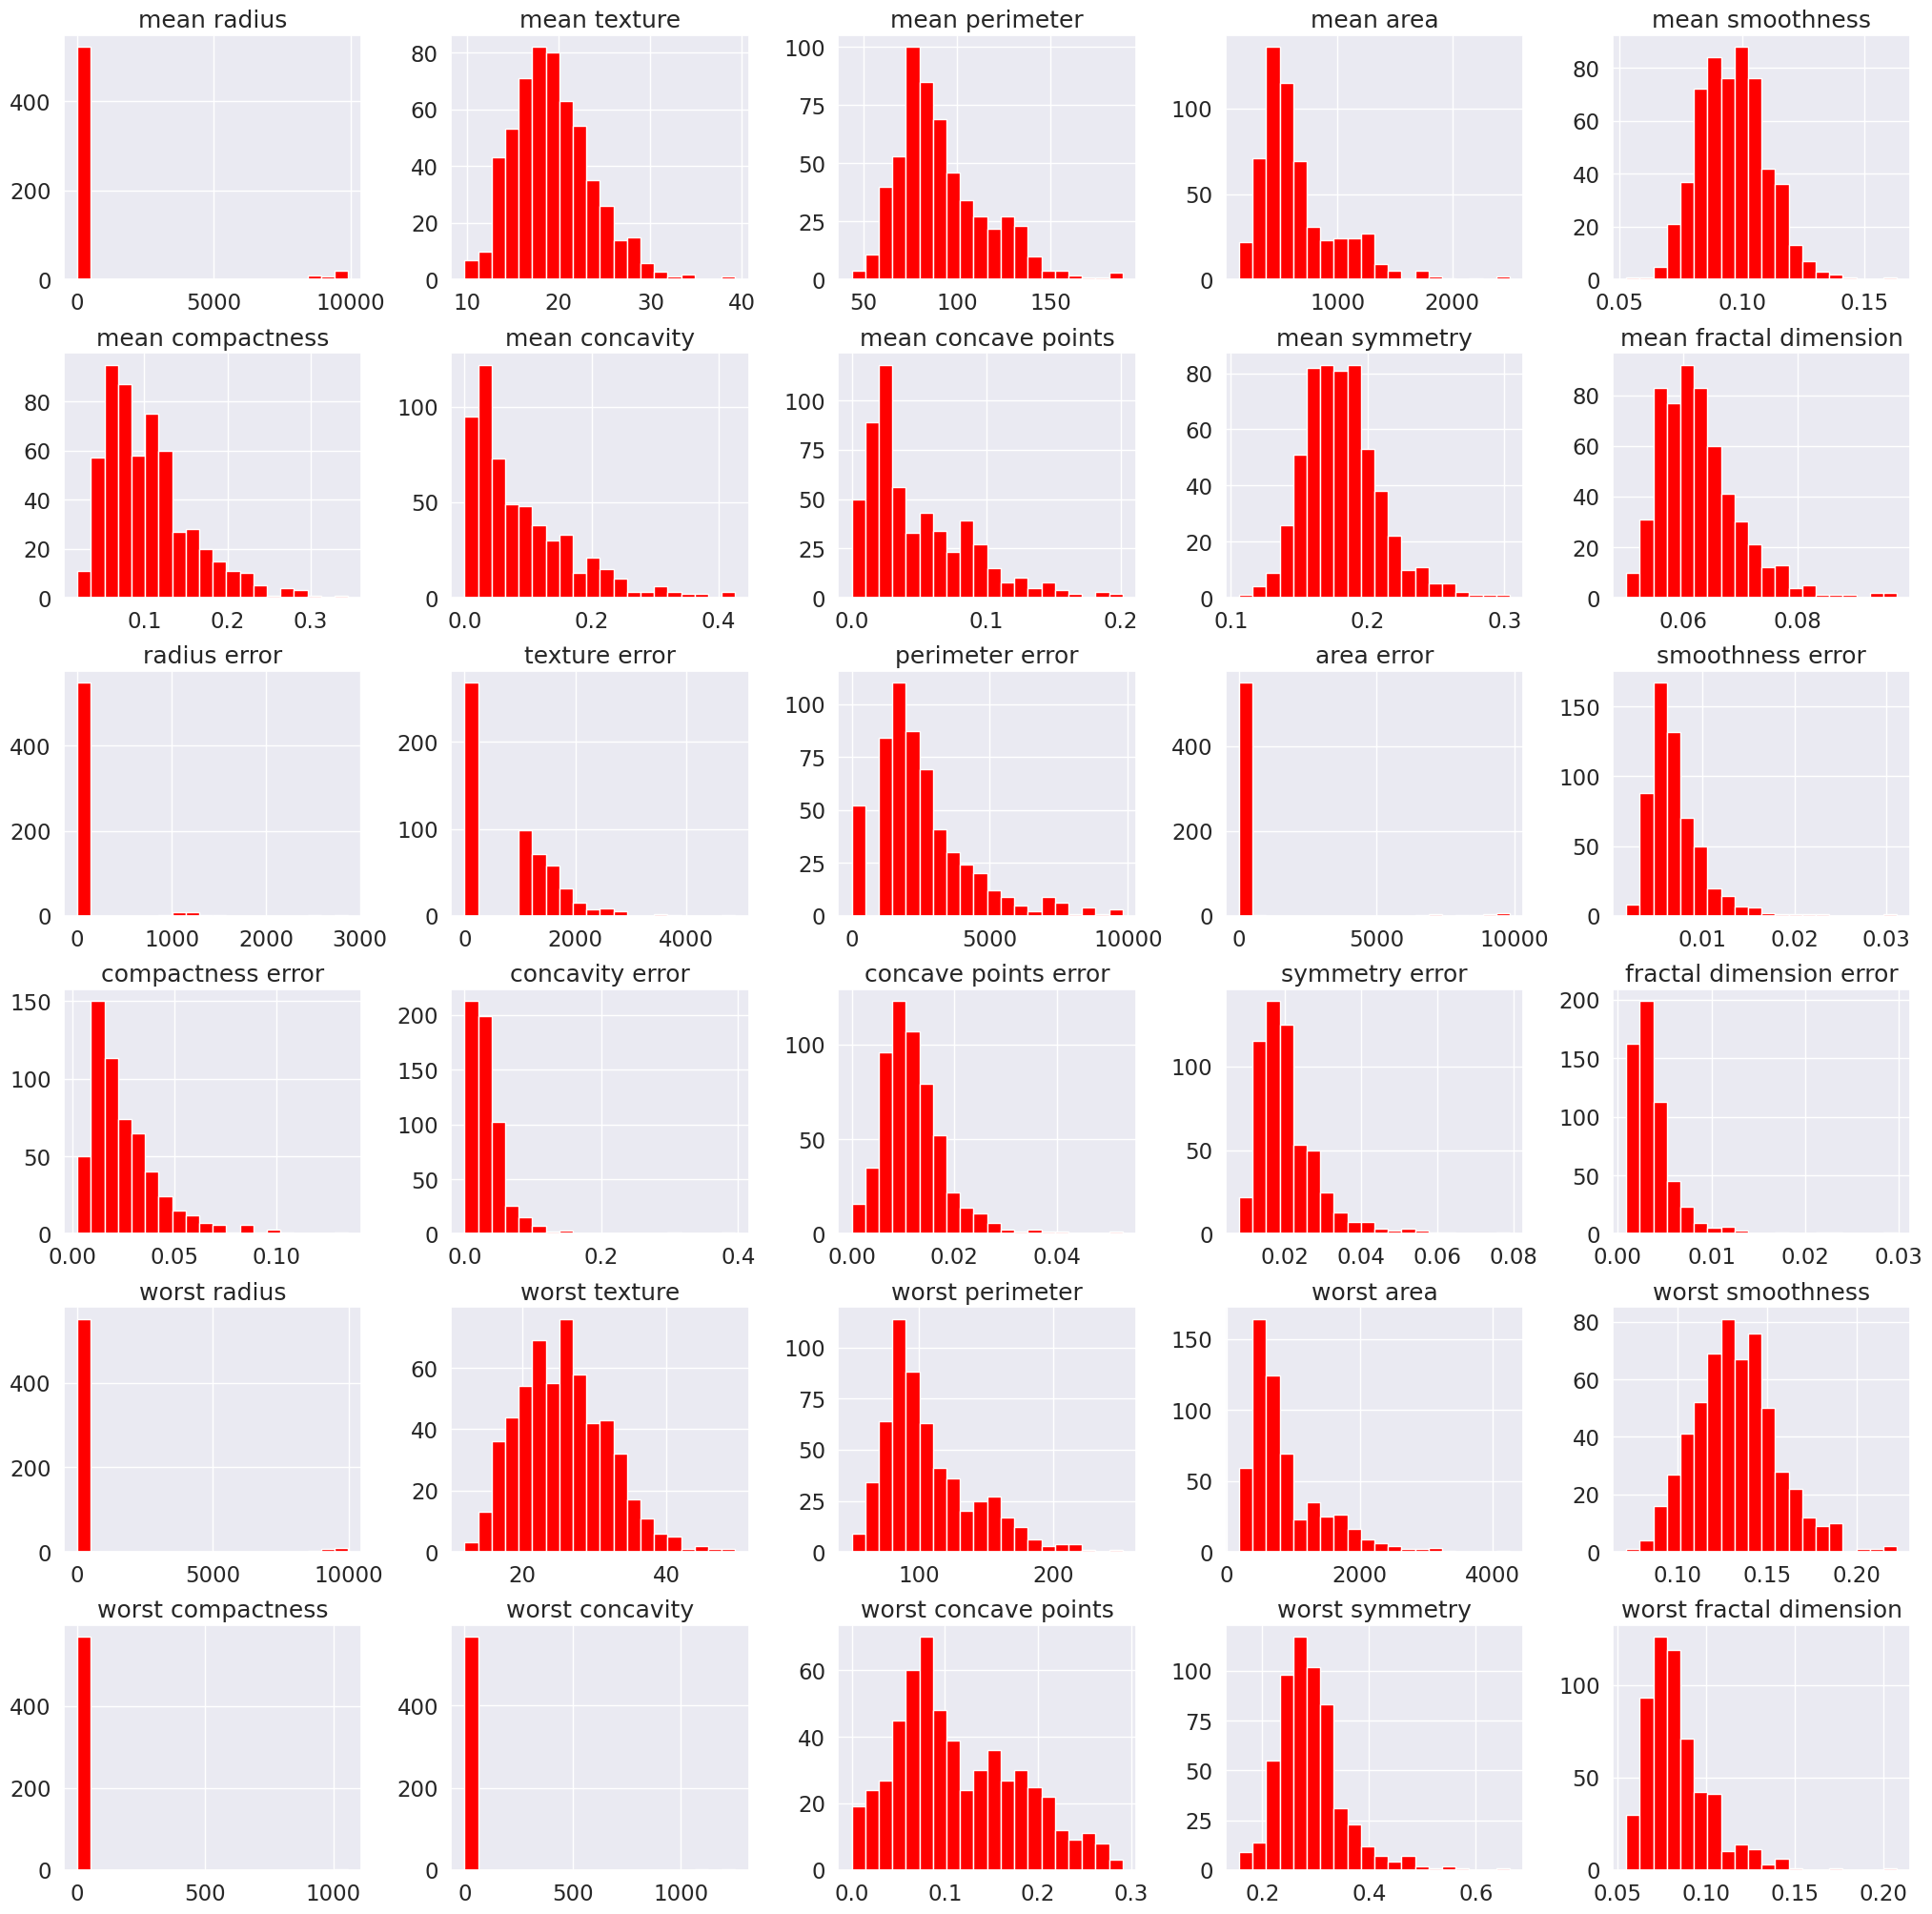

In [69]:
sns.set(font_scale=1.5,rc={'figure.figsize':(25,25)}) #usando a biblioteca sns posso verificar algumas distribuições dos meus dados
eixo=Dataset.hist(bins=20,color='red')

# Processing Some Variables

# Model Development and Results - Pipeline

In [70]:

processor = processing_data(base=Dataset.copy())
target='Malignant'
variavel='target'
type_method='mean'
multiclass=False

main_pipeline=Pipeline([#('float_values', FunctionTransformer(processor.float_values,
                         #                                    validate=False)),
                        ('target variable', FunctionTransformer(processor.target_variable,
                                             kw_args={'variavel': variavel, 'target':target, 'multiclass':multiclass})),
                       # ('Dummies', FunctionTransformer(processor.dummy_df,
                       #                     kw_args={'dummies': dummies},validate=False)),
                        ('Imput Values', FunctionTransformer(processor.impute_values,kw_args={'type_method':type_method},
                                                             validate=False)),
                        ('Normalize', FunctionTransformer(processor.normalize_df,
                                                          kw_args={'variavel': variavel},
                                                          validate=False)),

                        ])
X,y,Lista_variaveis=main_pipeline.fit_transform(Dataset)


Text(0.5, 1.0, 'Correlation Graph between Variables \n')

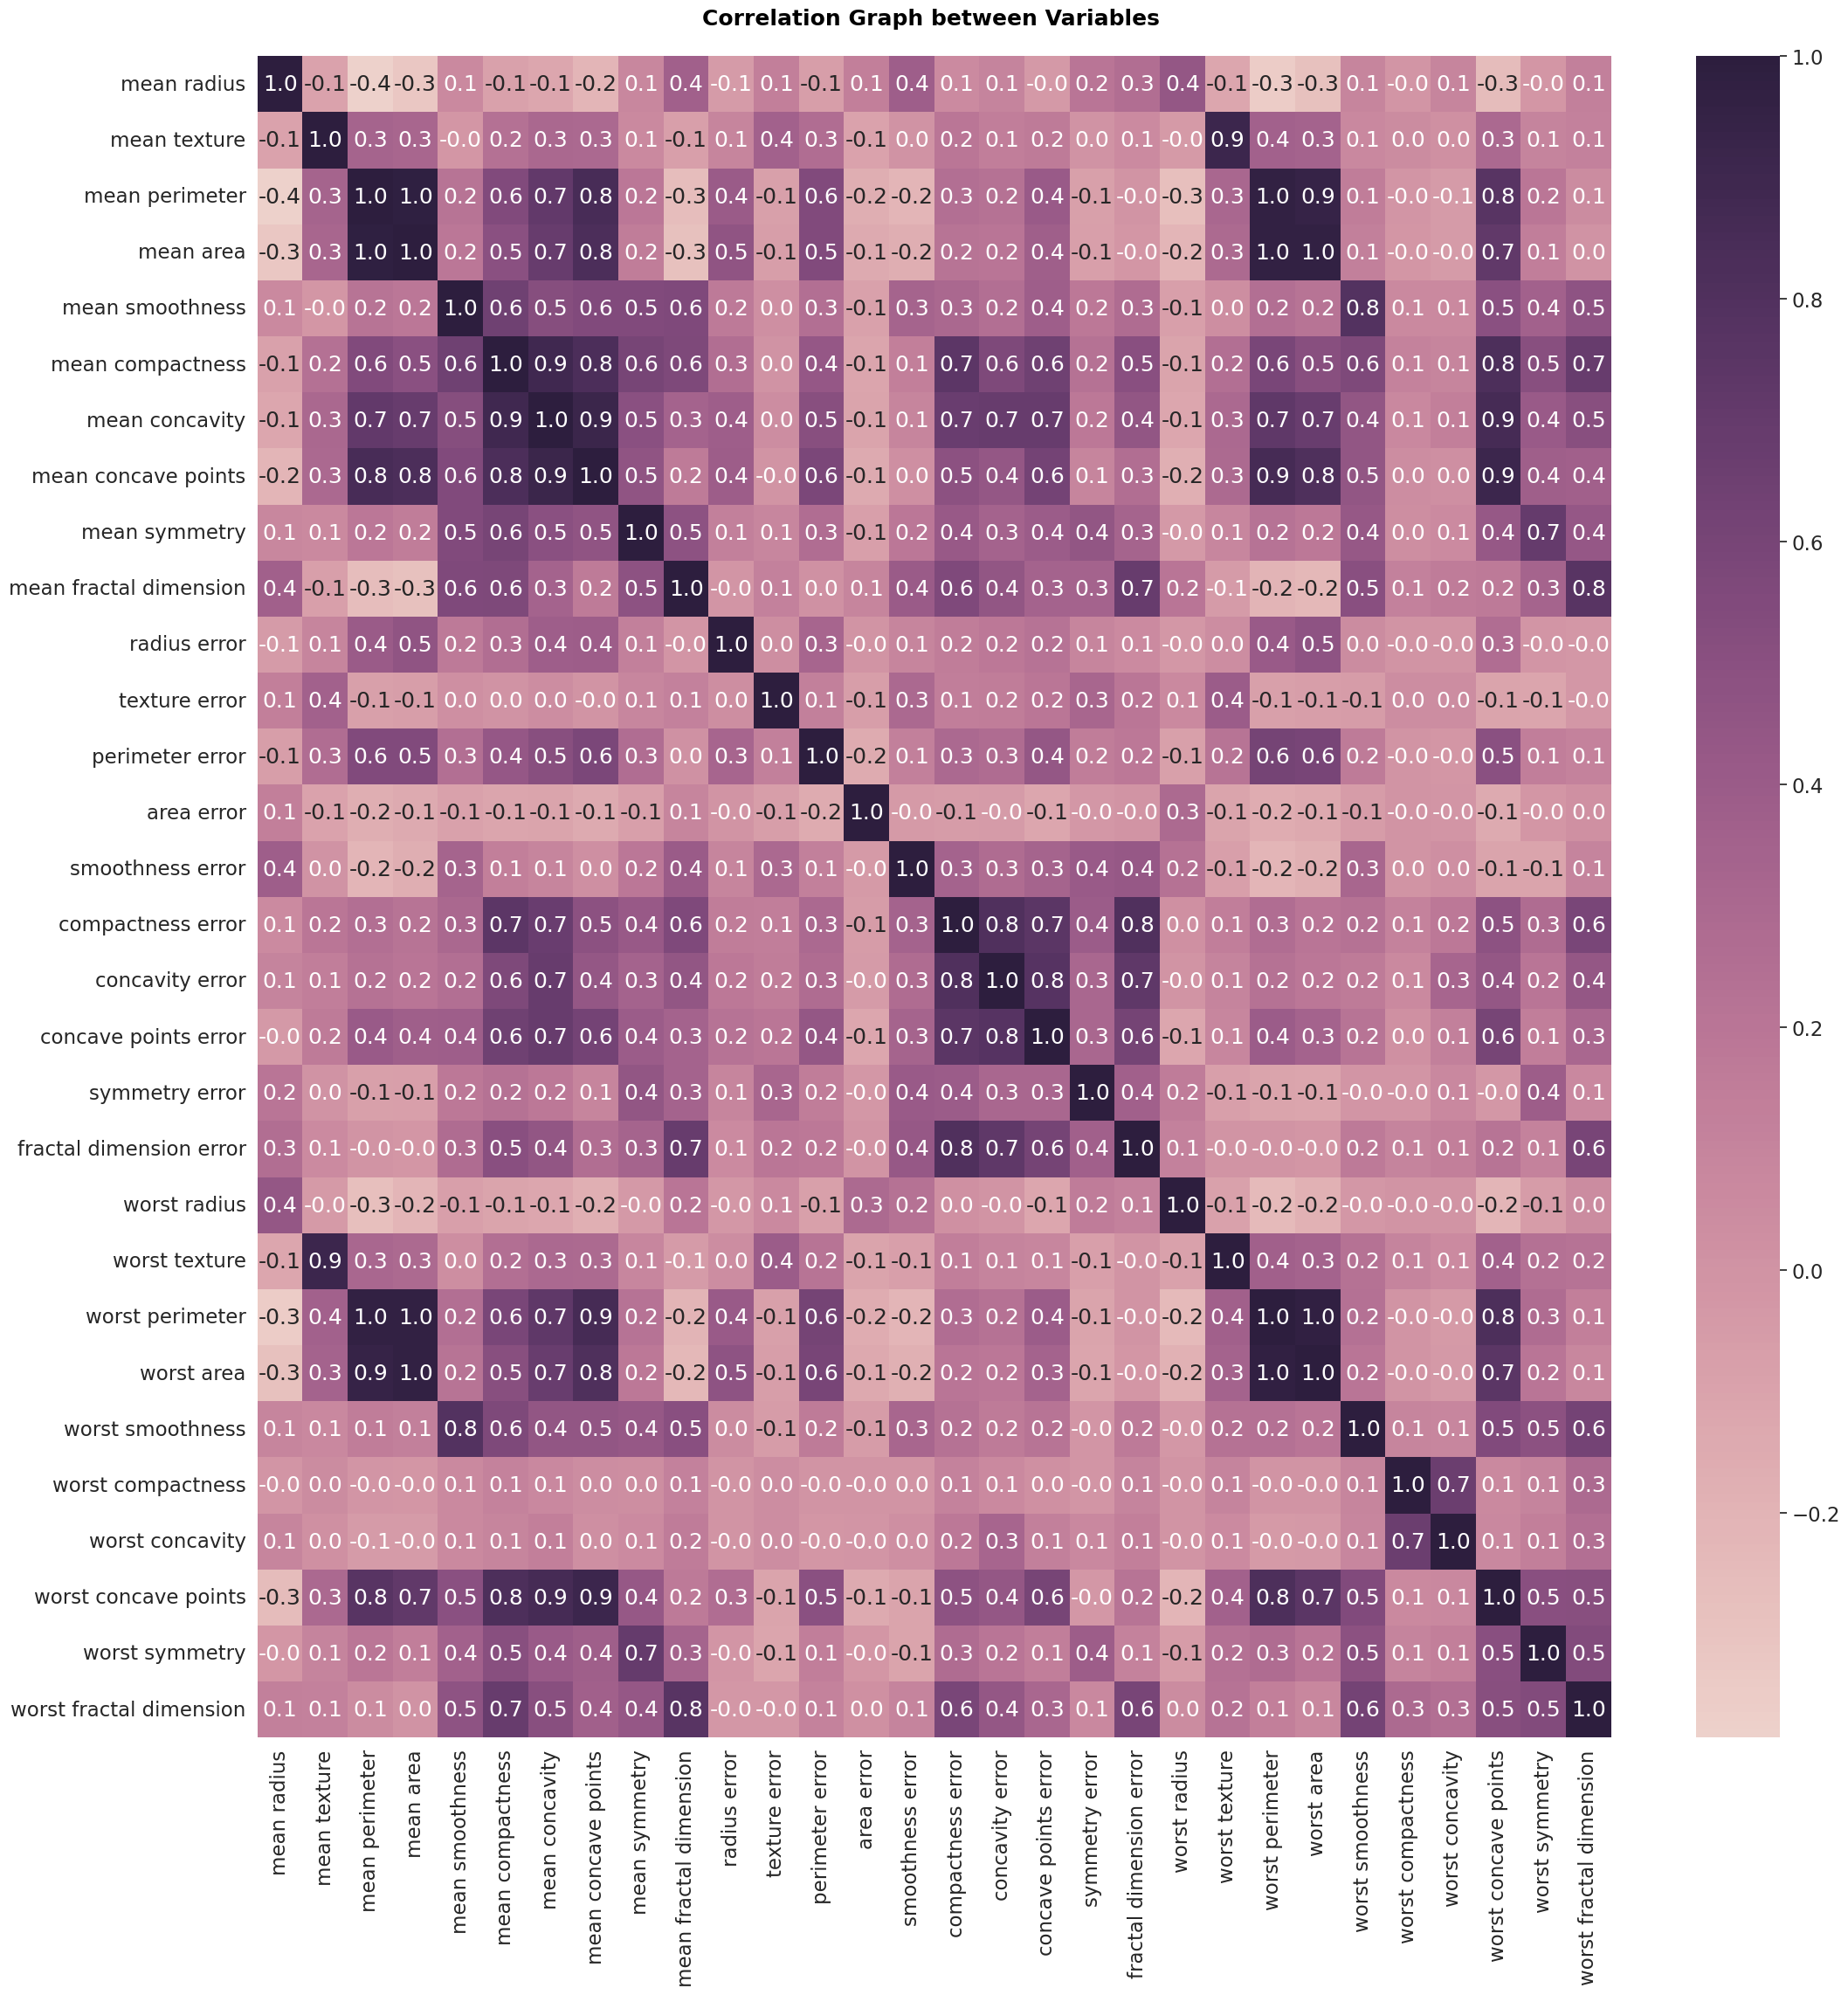

In [71]:
# Create correlation matrix
X_df = pd.DataFrame(X, columns=Lista_variaveis)  # Specify Lista_variaveis as columns
corr_mat = X_df.corr()

# Plot heatmap
plt.figure(figsize=(25, 25))
sns.heatmap(corr_mat, annot=True,
            fmt='.1f', cmap=sns.cubehelix_palette(200))
plt.title('Correlation Graph between Variables \n', weight="bold", color="#000000", fontsize=18)

Text(0.5, 1.0, 'Correlation Graph between Variables \n')

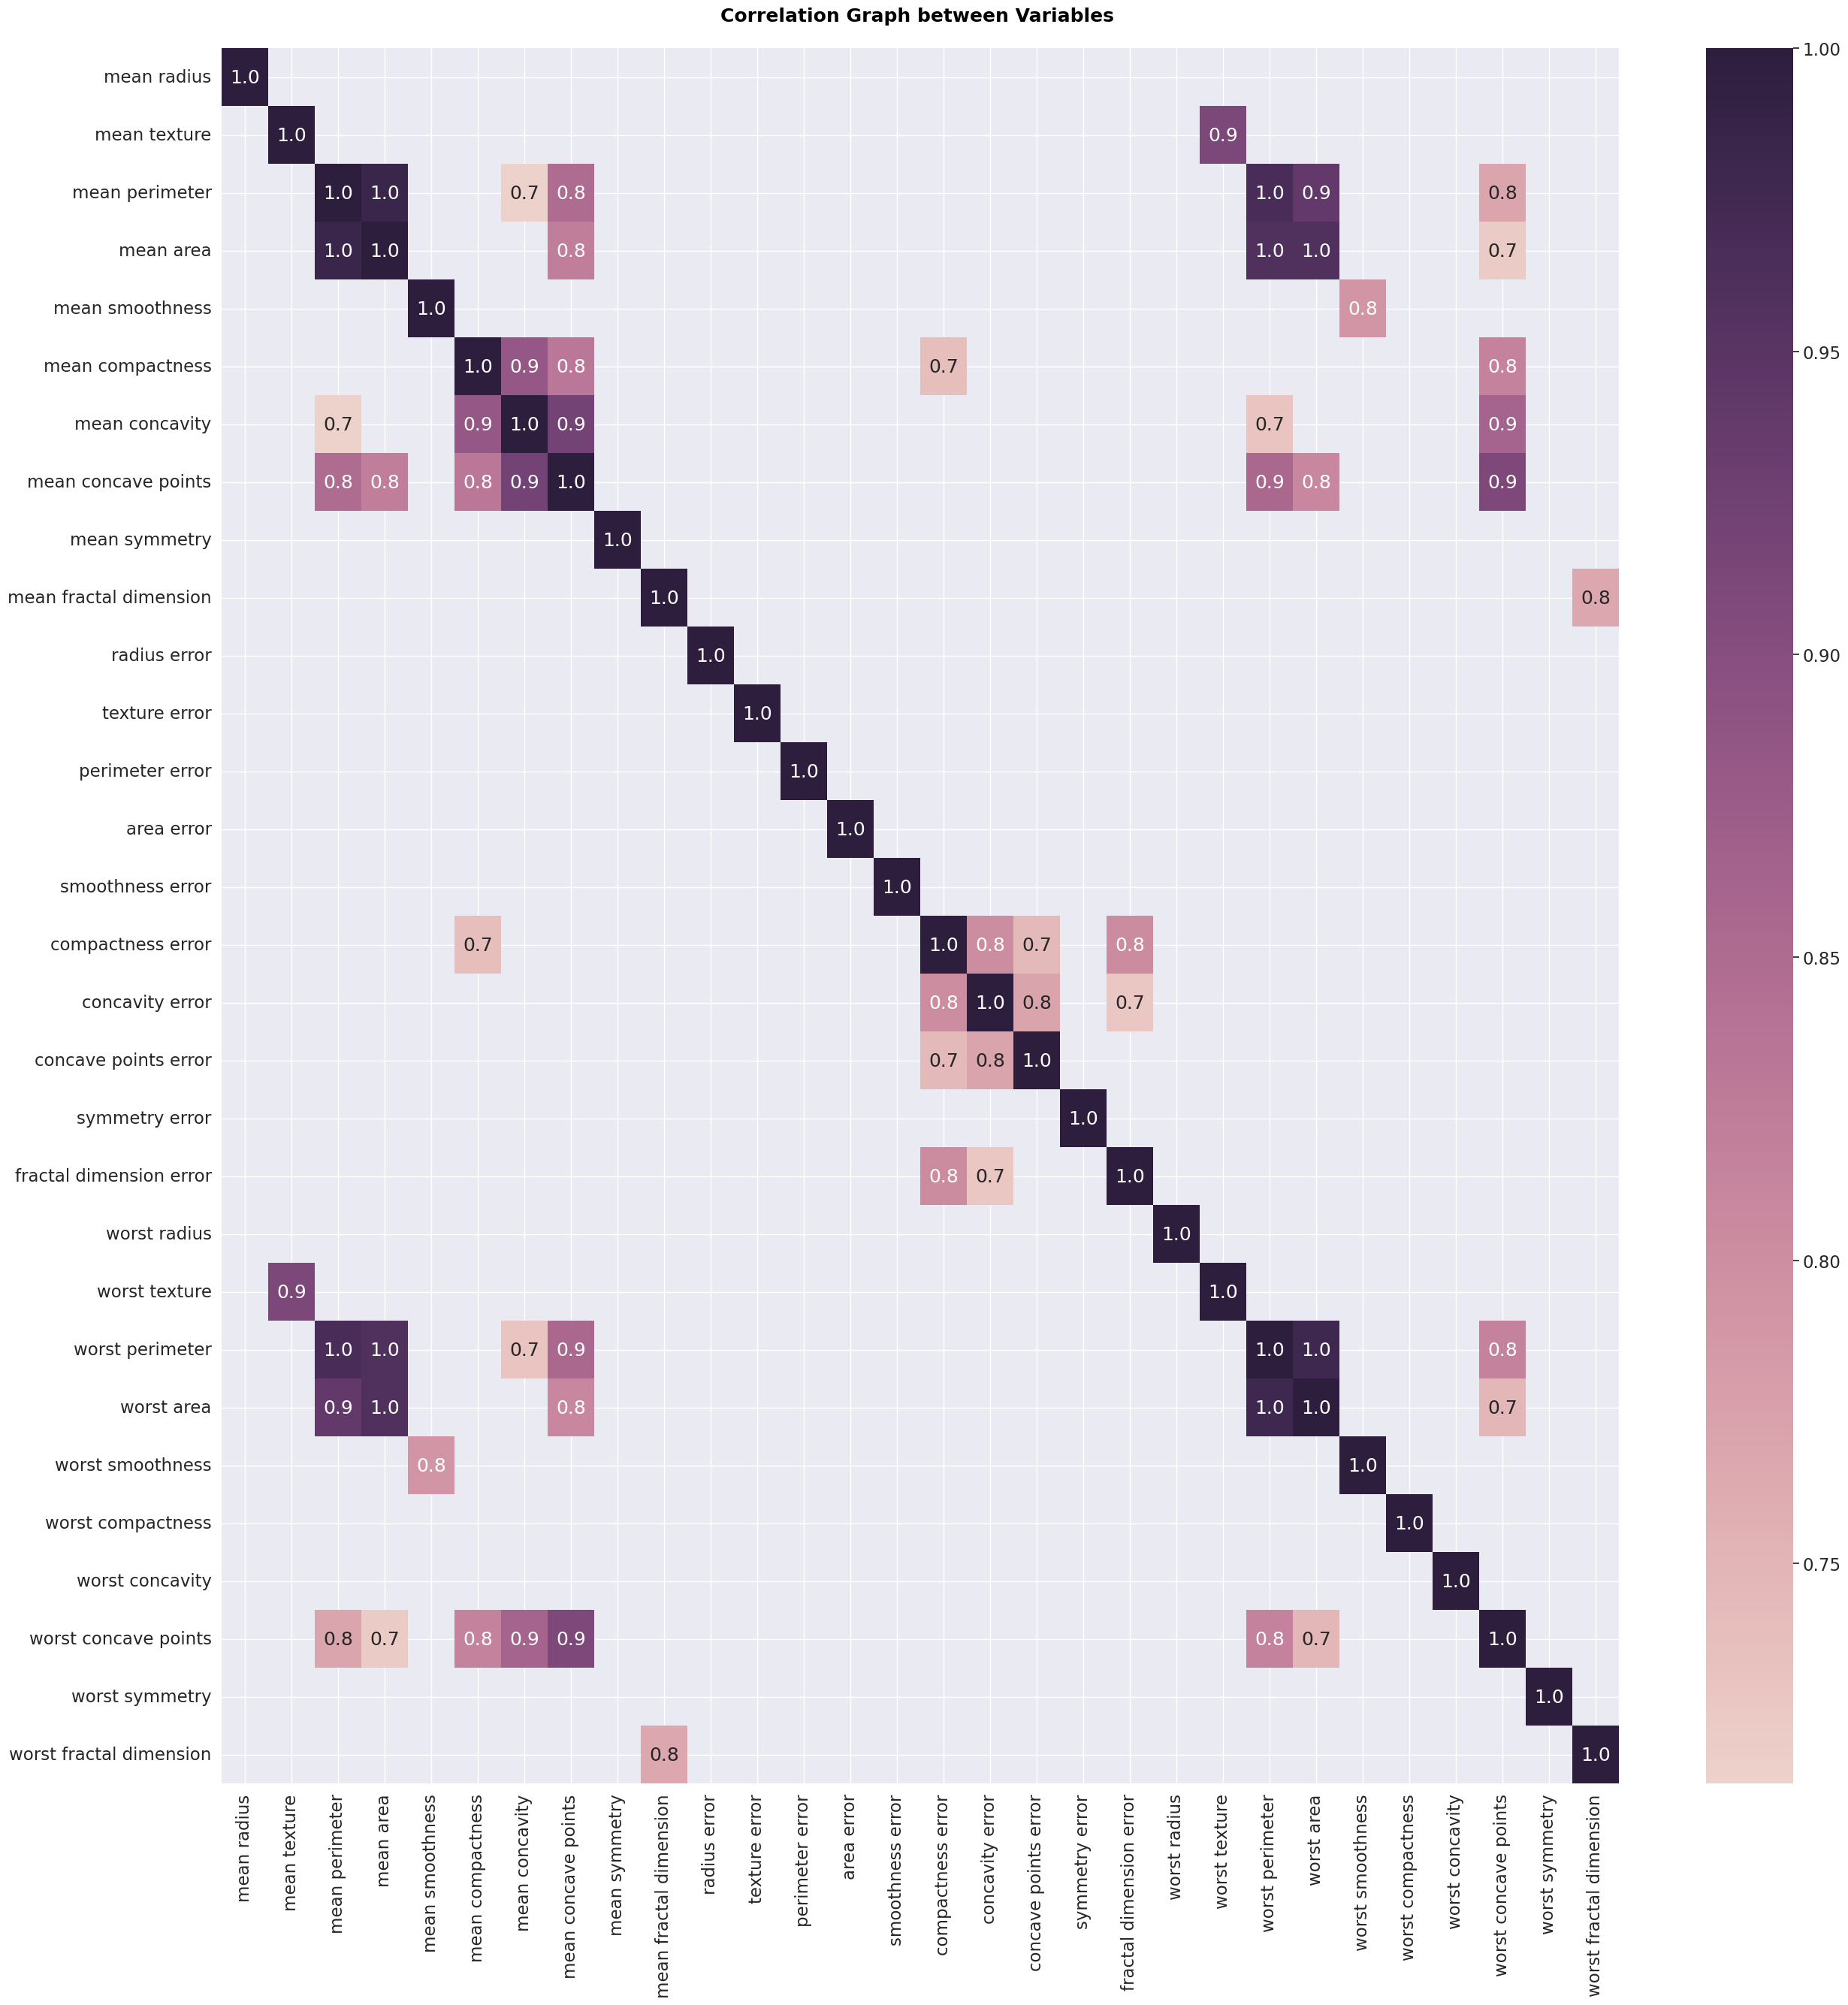

In [72]:
plt.figure(figsize=(30, 30))
sns.heatmap(corr_mat[corr_mat > 0.7], annot=True,
            fmt='.1f', cmap=sns.cubehelix_palette(200))
plt.title('Correlation Graph between Variables \n', weight="bold", color="#000000", fontsize=18)

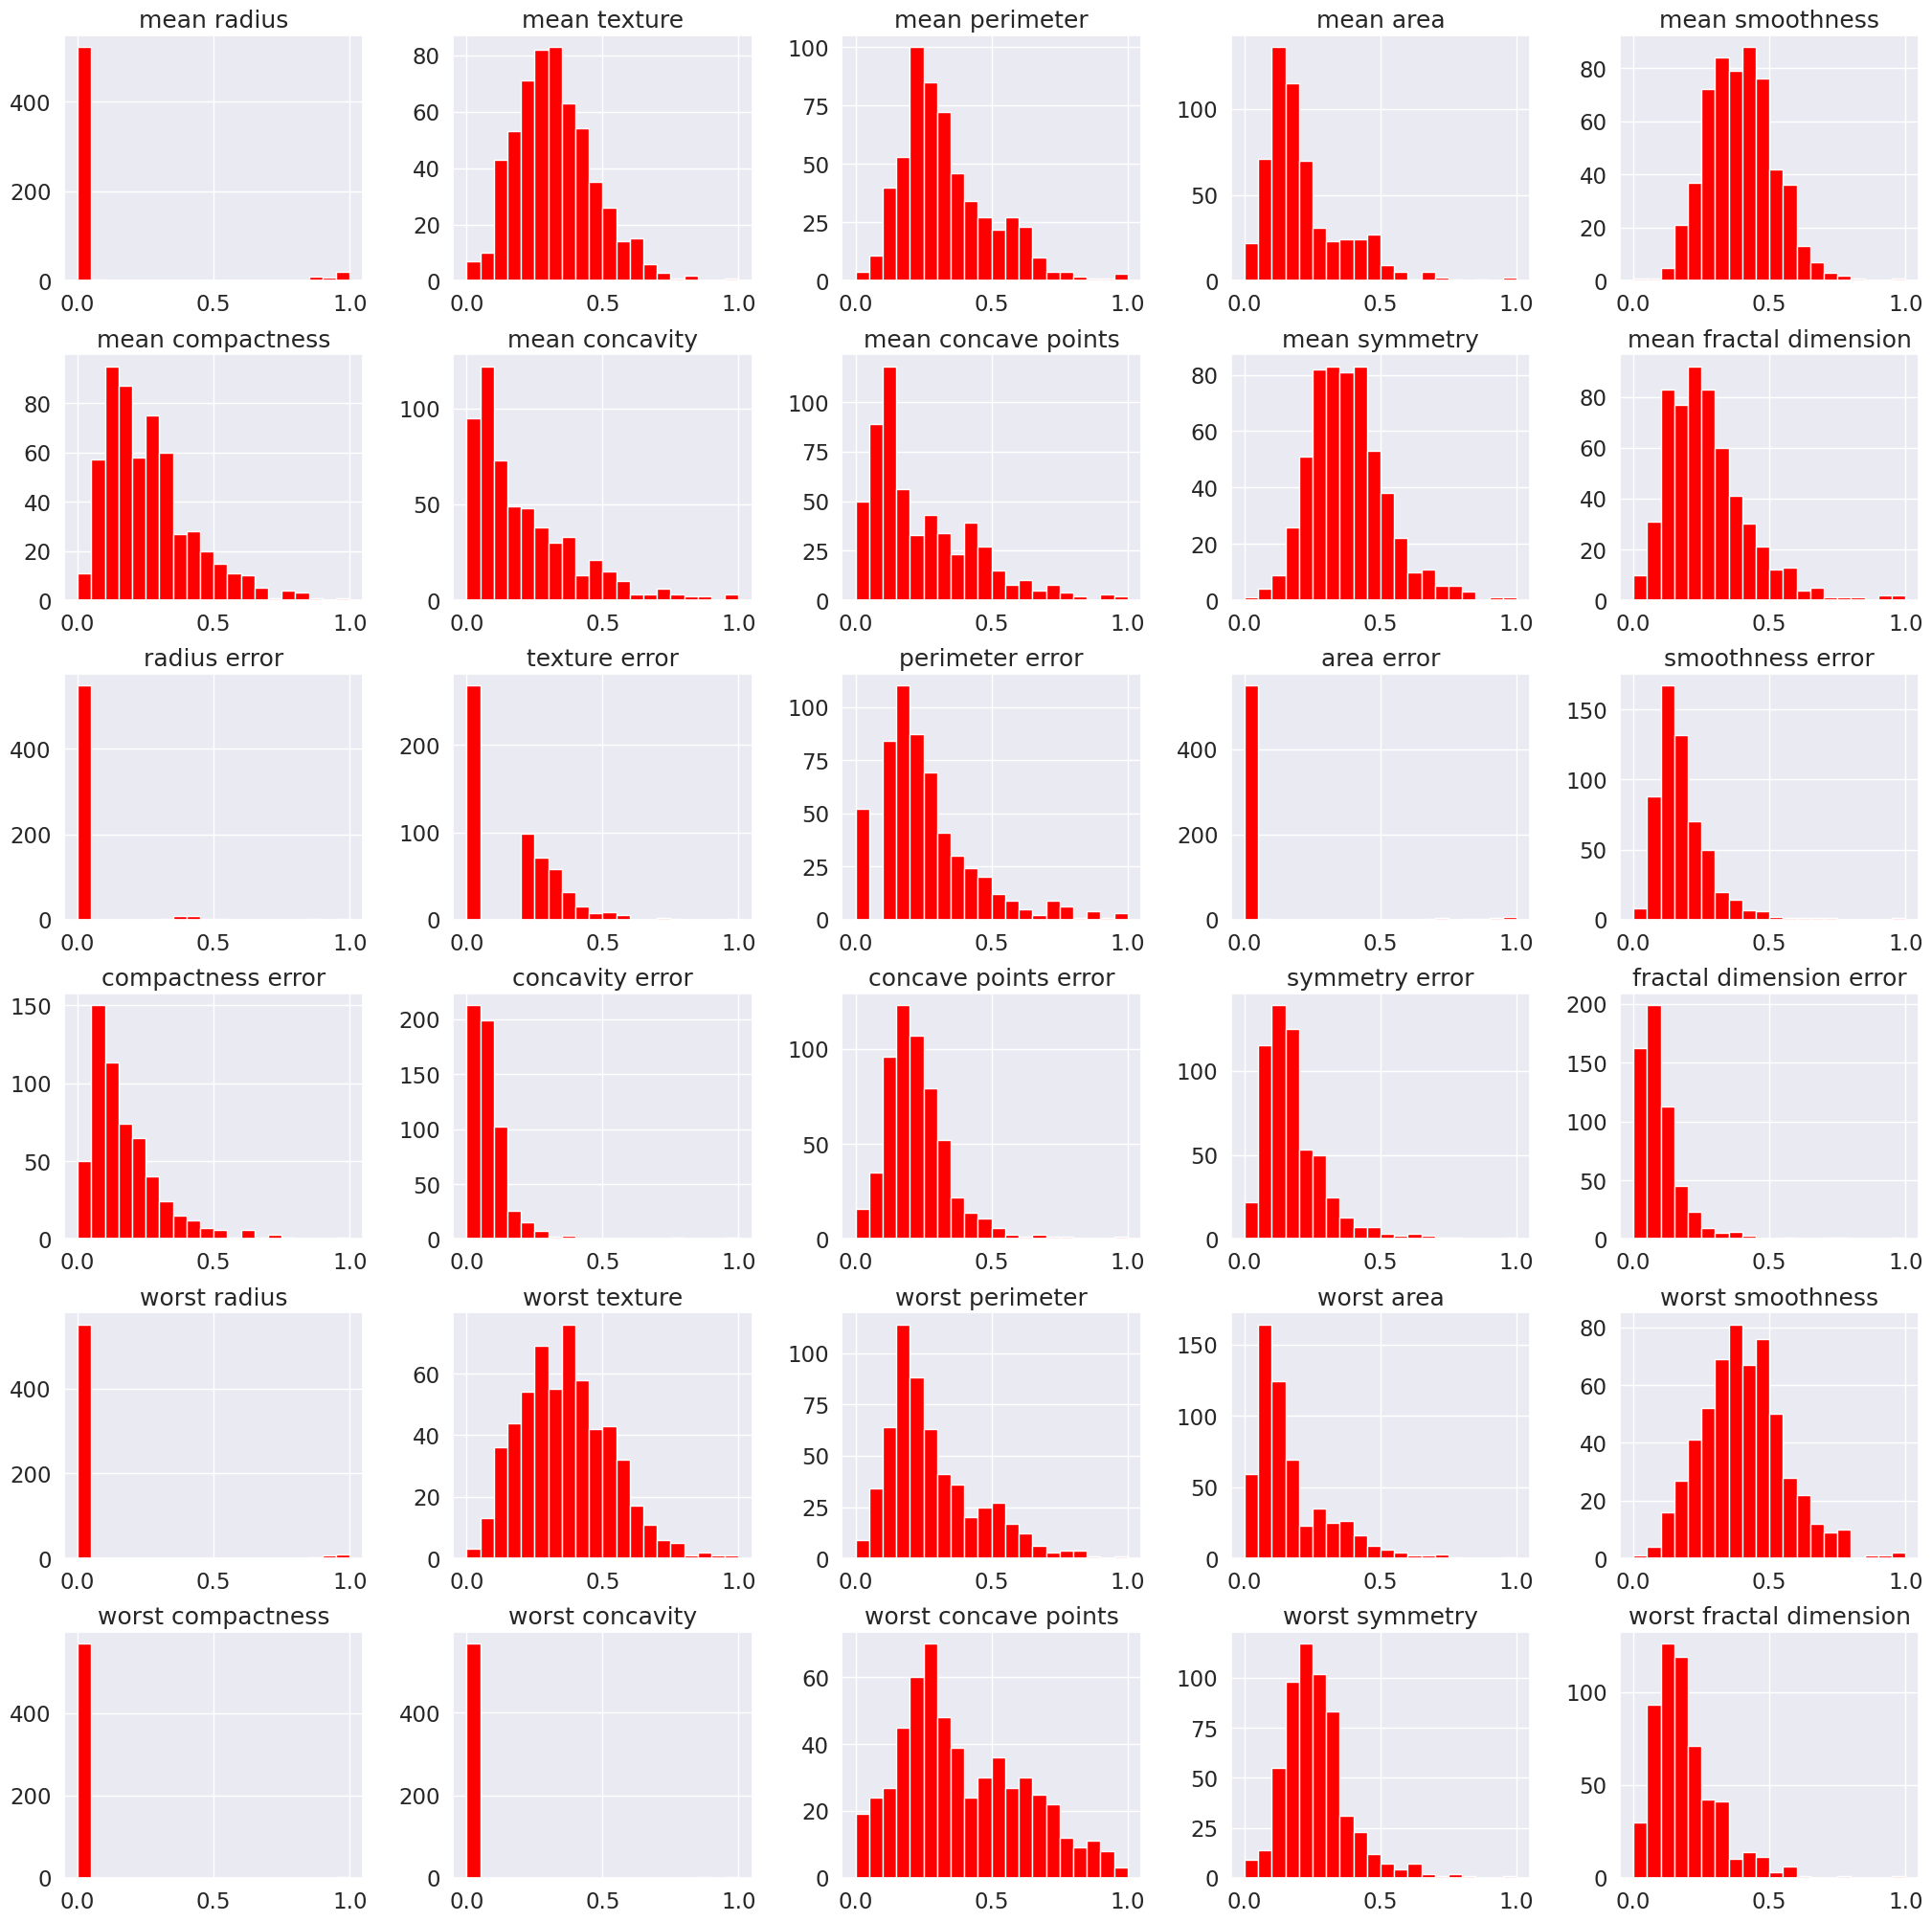

In [73]:
sns.set(font_scale=1.5,rc={'figure.figsize':(25,25)}) #usando a biblioteca sns posso verificar algumas distribuições dos meus dados
eixo=X_df.hist(bins=20,color='red')

In [74]:
import plotly.express as px

# Convert X to a pandas DataFrame with column names
X_df = pd.DataFrame(X, columns=Lista_variaveis)
X_df['target'] = y

# Create the histogram using the DataFrame and color mapping
histogram_diagnosis = px.histogram(
    X_df,
    x='target',
    color=X_df['target'],  # Map target values to colors
    title='Count Cases',
    text_auto=True,
)
histogram_diagnosis.show()

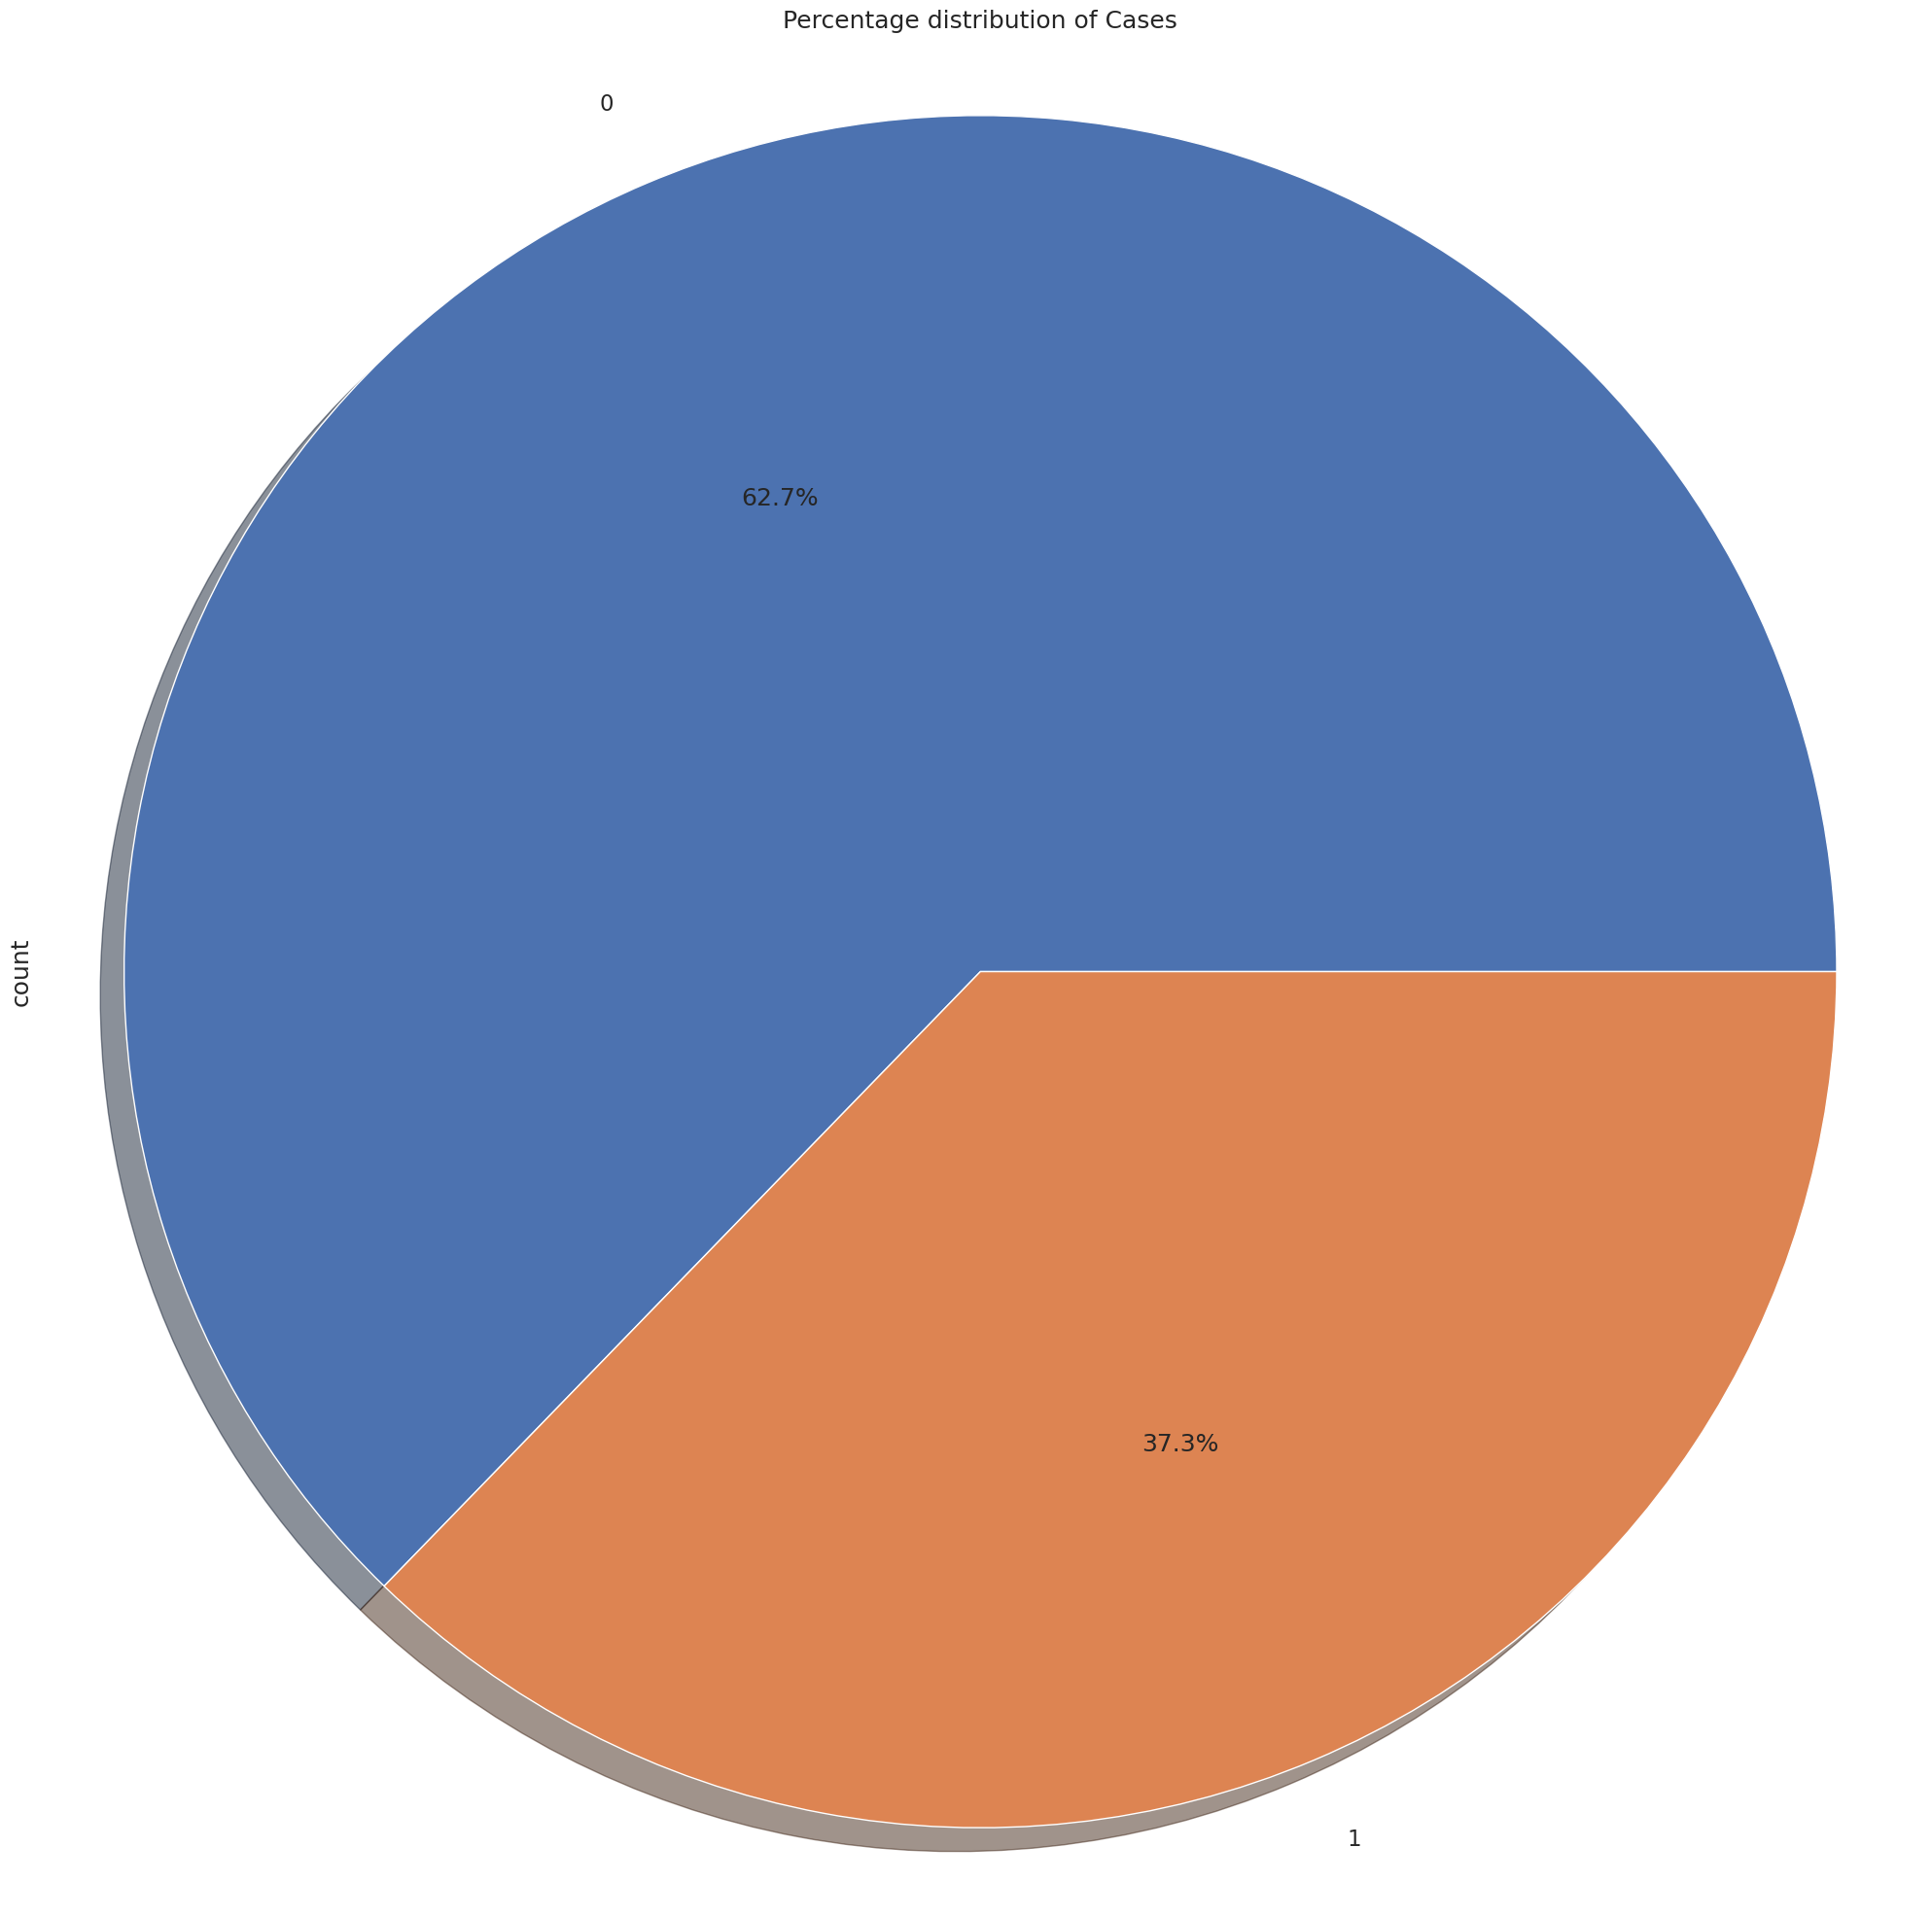

In [75]:
counts = X_df['target'].value_counts(dropna=False)
counts.plot.pie(autopct='%1.1f%%', shadow=True)
plt.title('Percentage distribution of Cases')
plt.axis('equal')
plt.show()

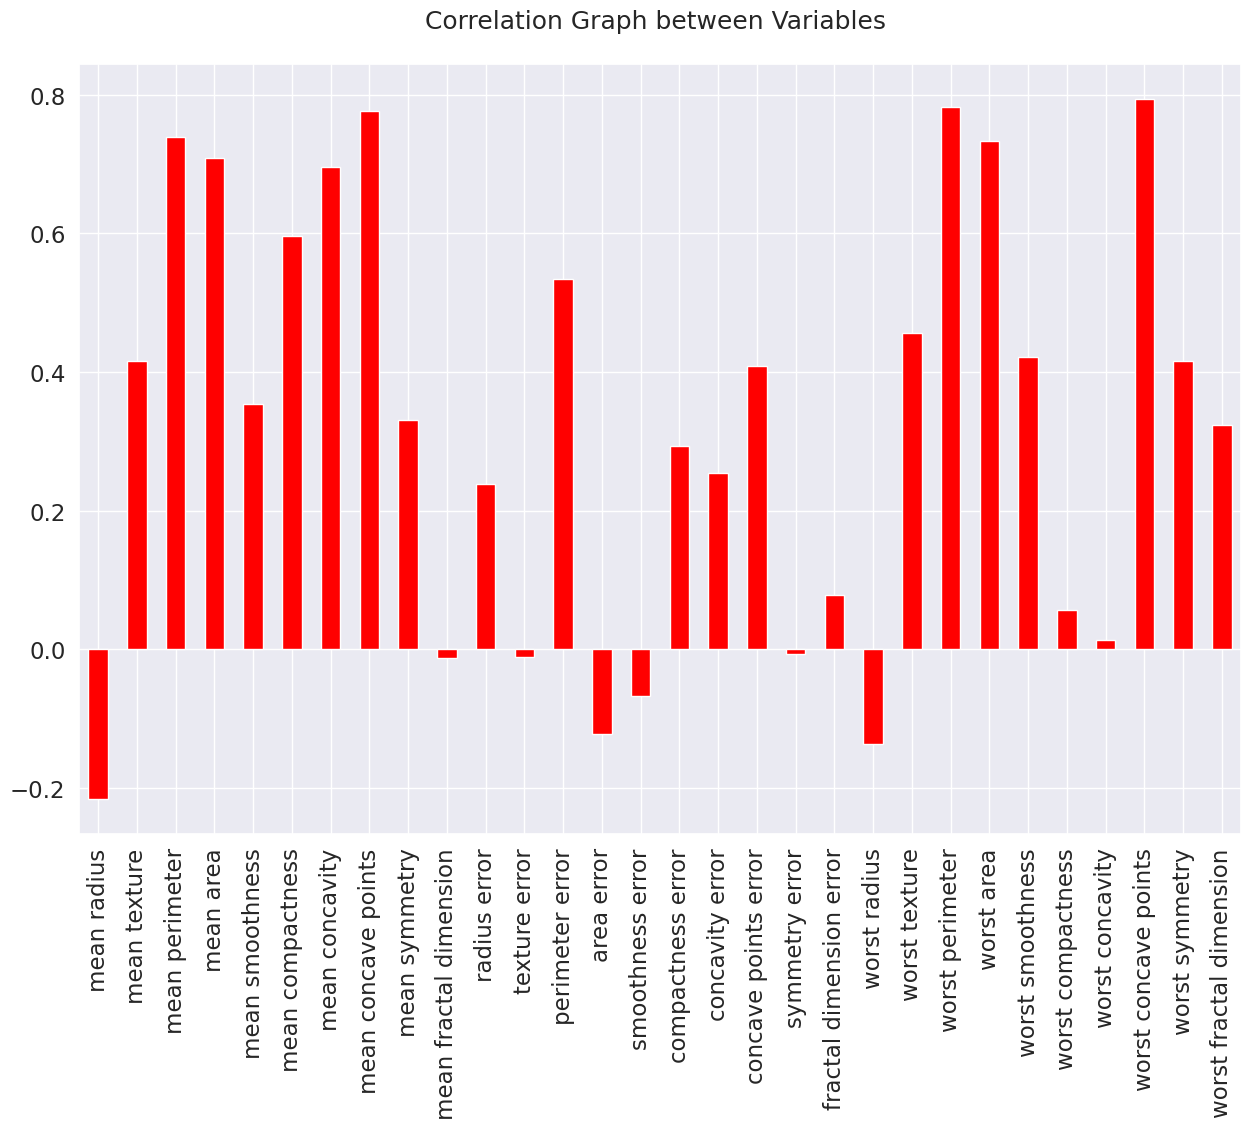

In [76]:
features = X_df.drop('target', axis=1)

correlation_with_diagnosis = features.corrwith(X_df['target'])
correlation_with_diagnosis.plot(kind='bar', grid=True, figsize=(15, 10), title="Correlation Graph between Variables \n", color="red")
plt.show()

In [77]:
batch_size=4
epochs=5
clusters=2
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2,random_state=0)

Epoch 1/5
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5765 - loss: 0.7165
Epoch 2/5
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6354 - loss: 0.6635
Epoch 3/5
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7166 - loss: 0.6030
Epoch 4/5
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8003 - loss: 0.5148
Epoch 5/5
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8112 - loss: 0.4699

Model Accuracy: 88.60%

F1 Score: 88.48%

Confussion Matrix


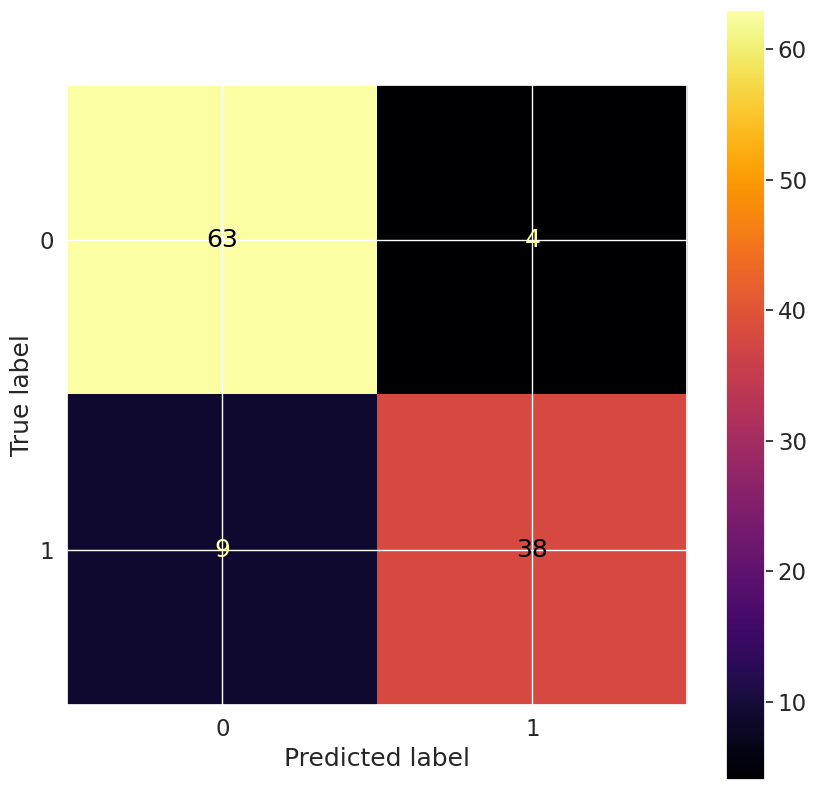


                     feature  importance
27     worst concave points    0.041228
0               mean radius    0.035965
7       mean concave points    0.021053
22          worst perimeter    0.020175
6            mean concavity    0.017544
28           worst symmetry    0.012281
3                 mean area    0.011404
2            mean perimeter    0.011404
5          mean compactness    0.008772
29  worst fractal dimension    0.007895
8             mean symmetry    0.007895
11            texture error    0.004386
23               worst area    0.004386
12          perimeter error    0.004386
1              mean texture    0.004386
20             worst radius    0.003509
4           mean smoothness    0.003509
9    mean fractal dimension    0.002632
19  fractal dimension error    0.002632
13               area error    0.001754
15        compactness error    0.001754
16          concavity error    0.000877
10             radius error    0.000000
25        worst compactness    0.00000

'processor_Neuro.models_metrics_neuro(model, Xtrain, ytrain, Xtest, ytest)\n# Convert predictions to binary class labels\npredition_1 = model.predict(Xtest, verbose=0) # Predict probabilities for the test set\npredition_1 = np.argmax(predition_1, axis=1) # Get the class with the highest probability\nmodel_neuro = accuracy_score(ytest, predition_1)\nprint("\nModel Accuracy: {:.2%}".format(model_neuro))\nprint(\'\n Confussion Matrix\')\ncf_matrix = confusion_matrix(ytest, predition_1)\nsns.heatmap(cf_matrix, annot=True).set_title(\'Confusion Matrix\')\n\n# Calculate permutation feature importance using the scoring function\nresult = permutation_importance(\n    model, Xtest, ytest, n_repeats=10, random_state=0, scoring=processor_Neuro.scoring_fn\n)\n# Create a DataFrame to store the results\nfeature_importances = pd.DataFrame(\n    {\n        "feature": Lista_variaveis,  # Assuming Lista_variaveis contains feature names\n        "importance": result.importances_mean,\n    }\n).sort_value

In [65]:
#Neural Network
type_model='Neural Network'
processor_Neuro = models_types(X=Xtrain,y=ytrain,Lista_variaveis=Lista_variaveis,batch_size=batch_size,epochs=epochs)
model = processor_Neuro.neuro_model()
processor_Neuro.metrics_class(model, Xtrain, ytrain, Xtest, ytest,type_model)

Best Parameters gini 8

Model Accuracy: 92.98%

F1 Score: 93.00%

Confussion Matrix


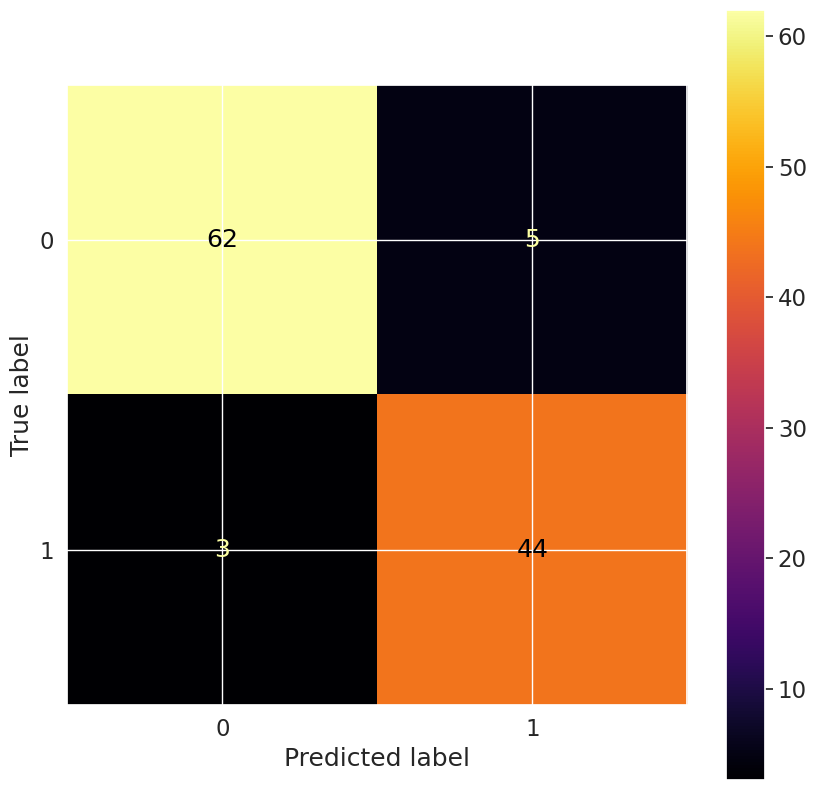


 Feature Importance
importance    30
dtype: int64


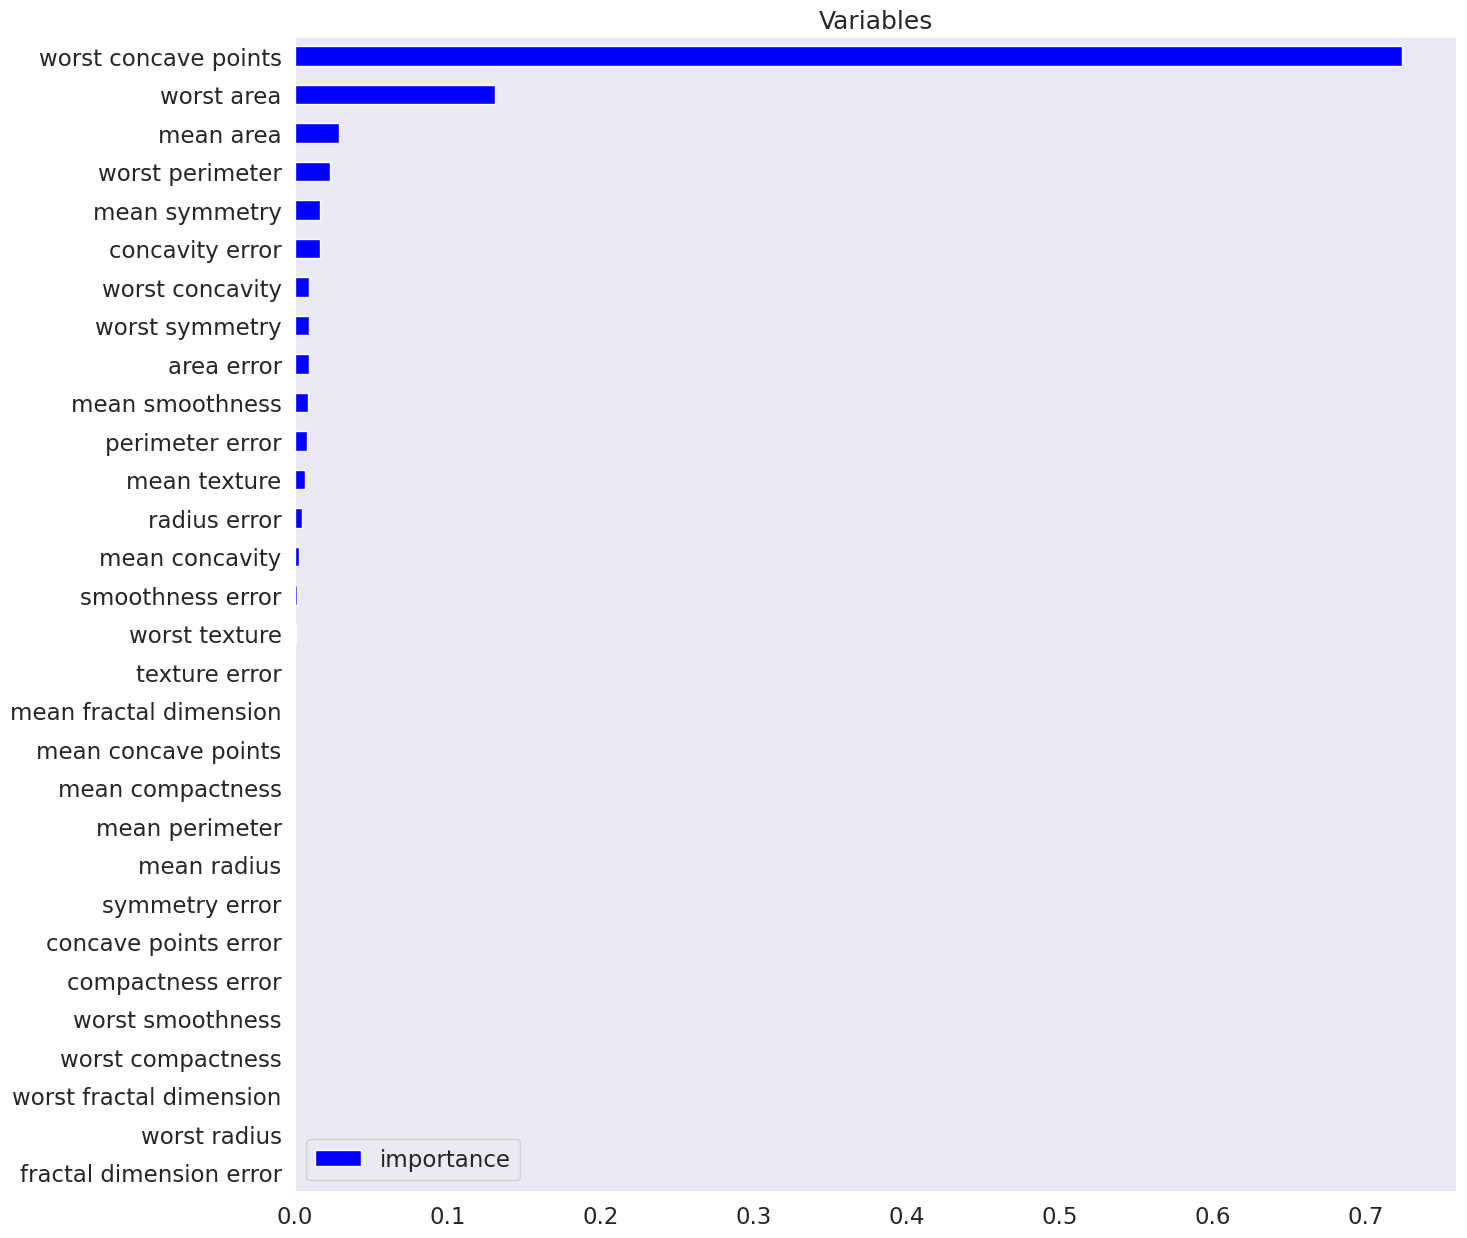

In [78]:
#Decission Tree
type_model='Decission Tree'
processor_decission_tree = models_types(X=Xtrain,y=ytrain,Lista_variaveis=Lista_variaveis,model_tree='Decission Tree')
model= processor_decission_tree.tree_and_random_forest()
processor_decission_tree.metrics_class(model, Xtrain, ytrain, Xtest, ytest,type_model)

Best Parameters 100 6

Model Accuracy: 96.49%

F1 Score: 96.49%

Confussion Matrix


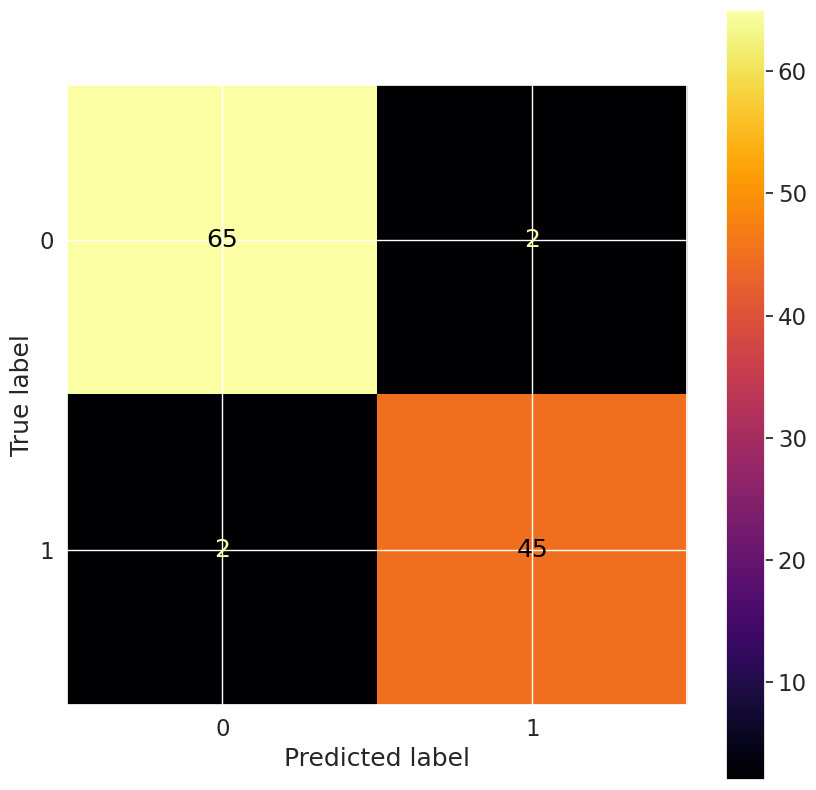


 Feature Importance
importance    30
dtype: int64


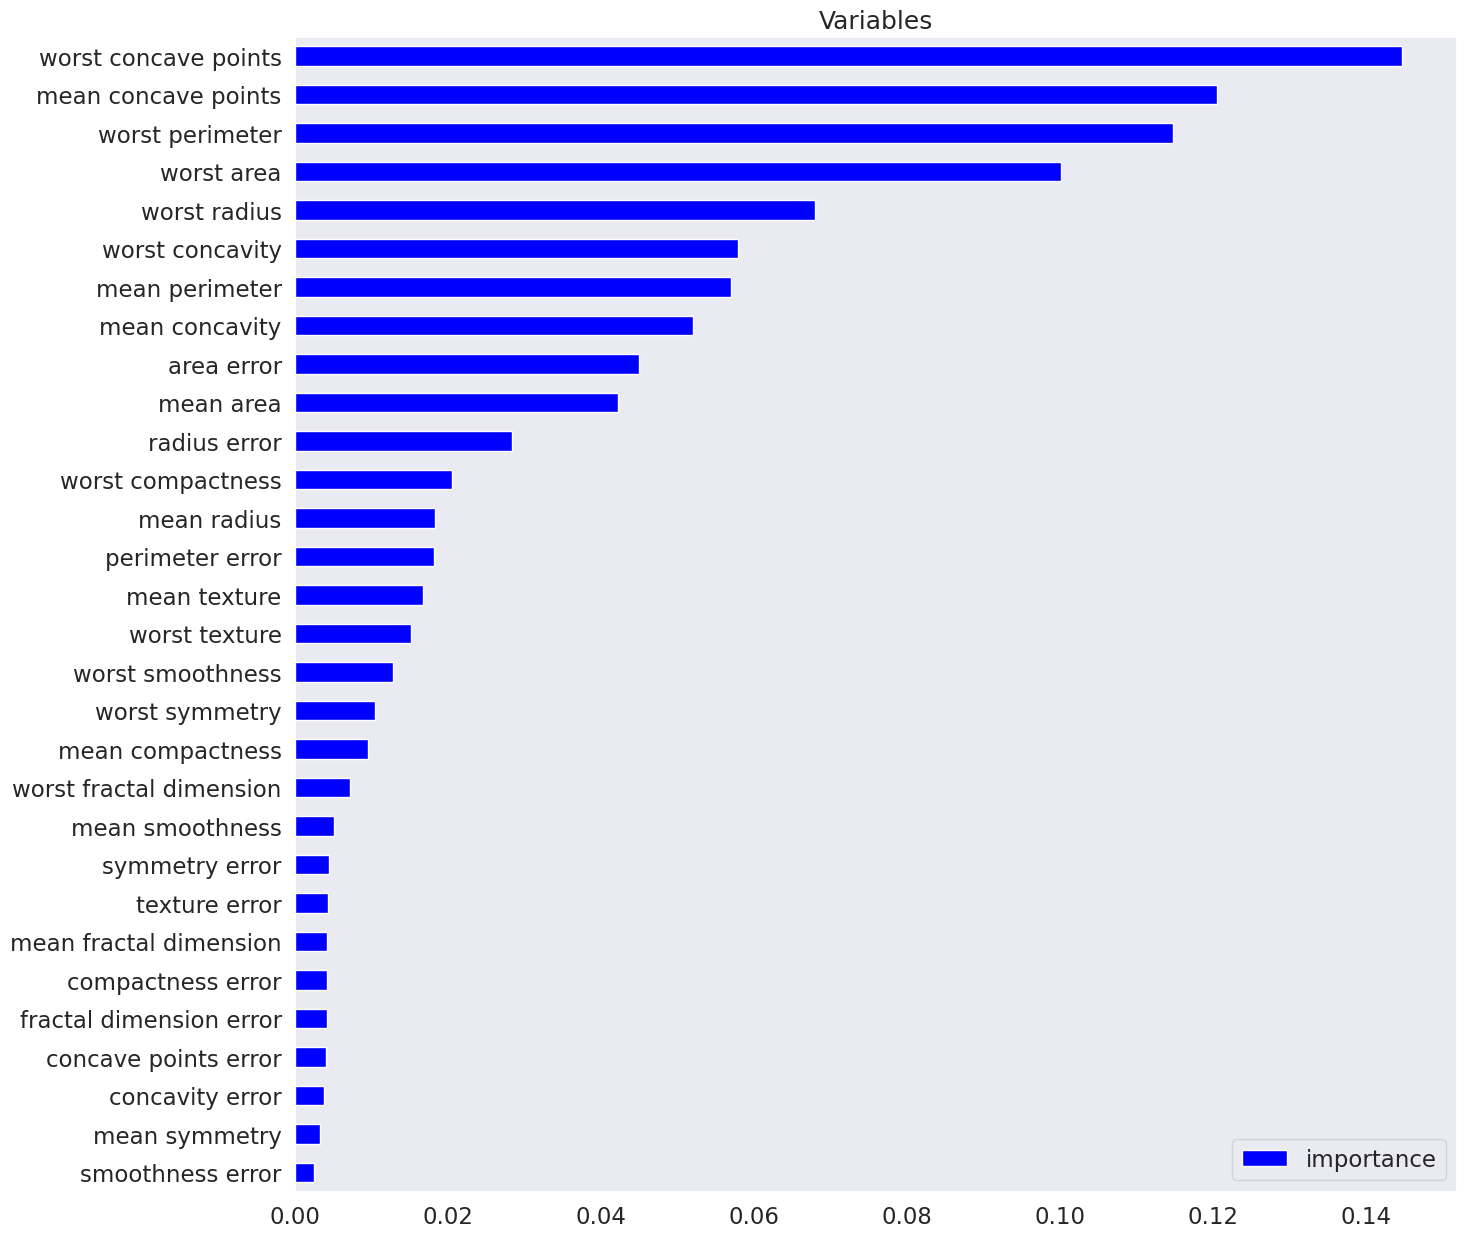

In [79]:
#Random Forest
type_model='Random Forest'
processor_randomf = models_types(X=Xtrain,y=ytrain,Lista_variaveis=Lista_variaveis,model_tree='Random Forest')
model= processor_randomf.tree_and_random_forest()
processor_randomf.metrics_class(model, Xtrain, ytrain, Xtest, ytest,type_model)

Best Parameters {'max_iter': 10, 'solver': 'lbfgs'}

Model Accuracy: 95.61%

F1 Score: 95.57%

Confussion Matrix


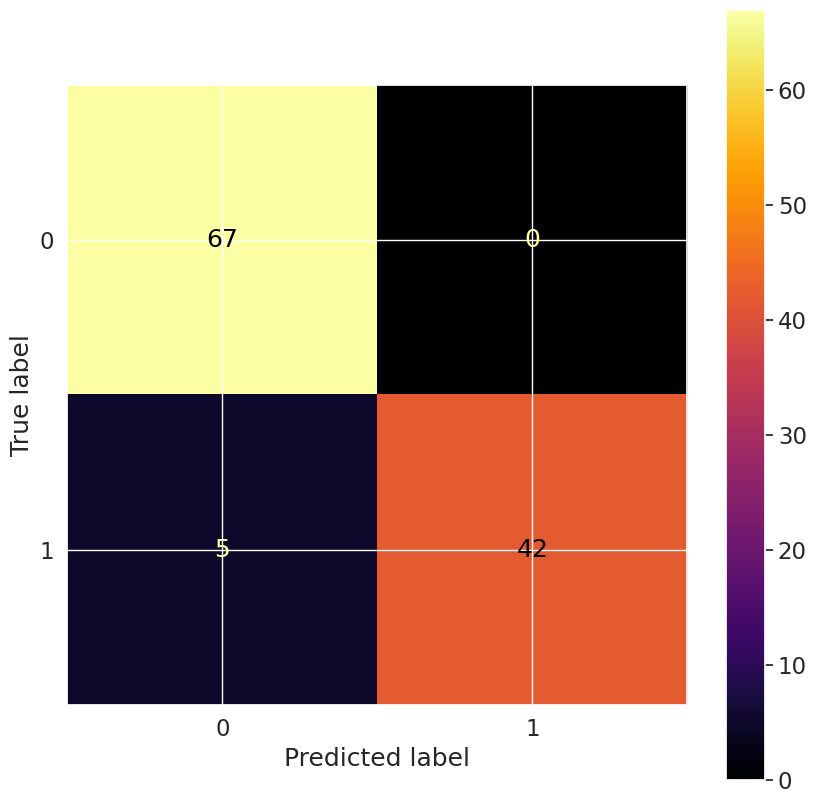


 Feature Importance


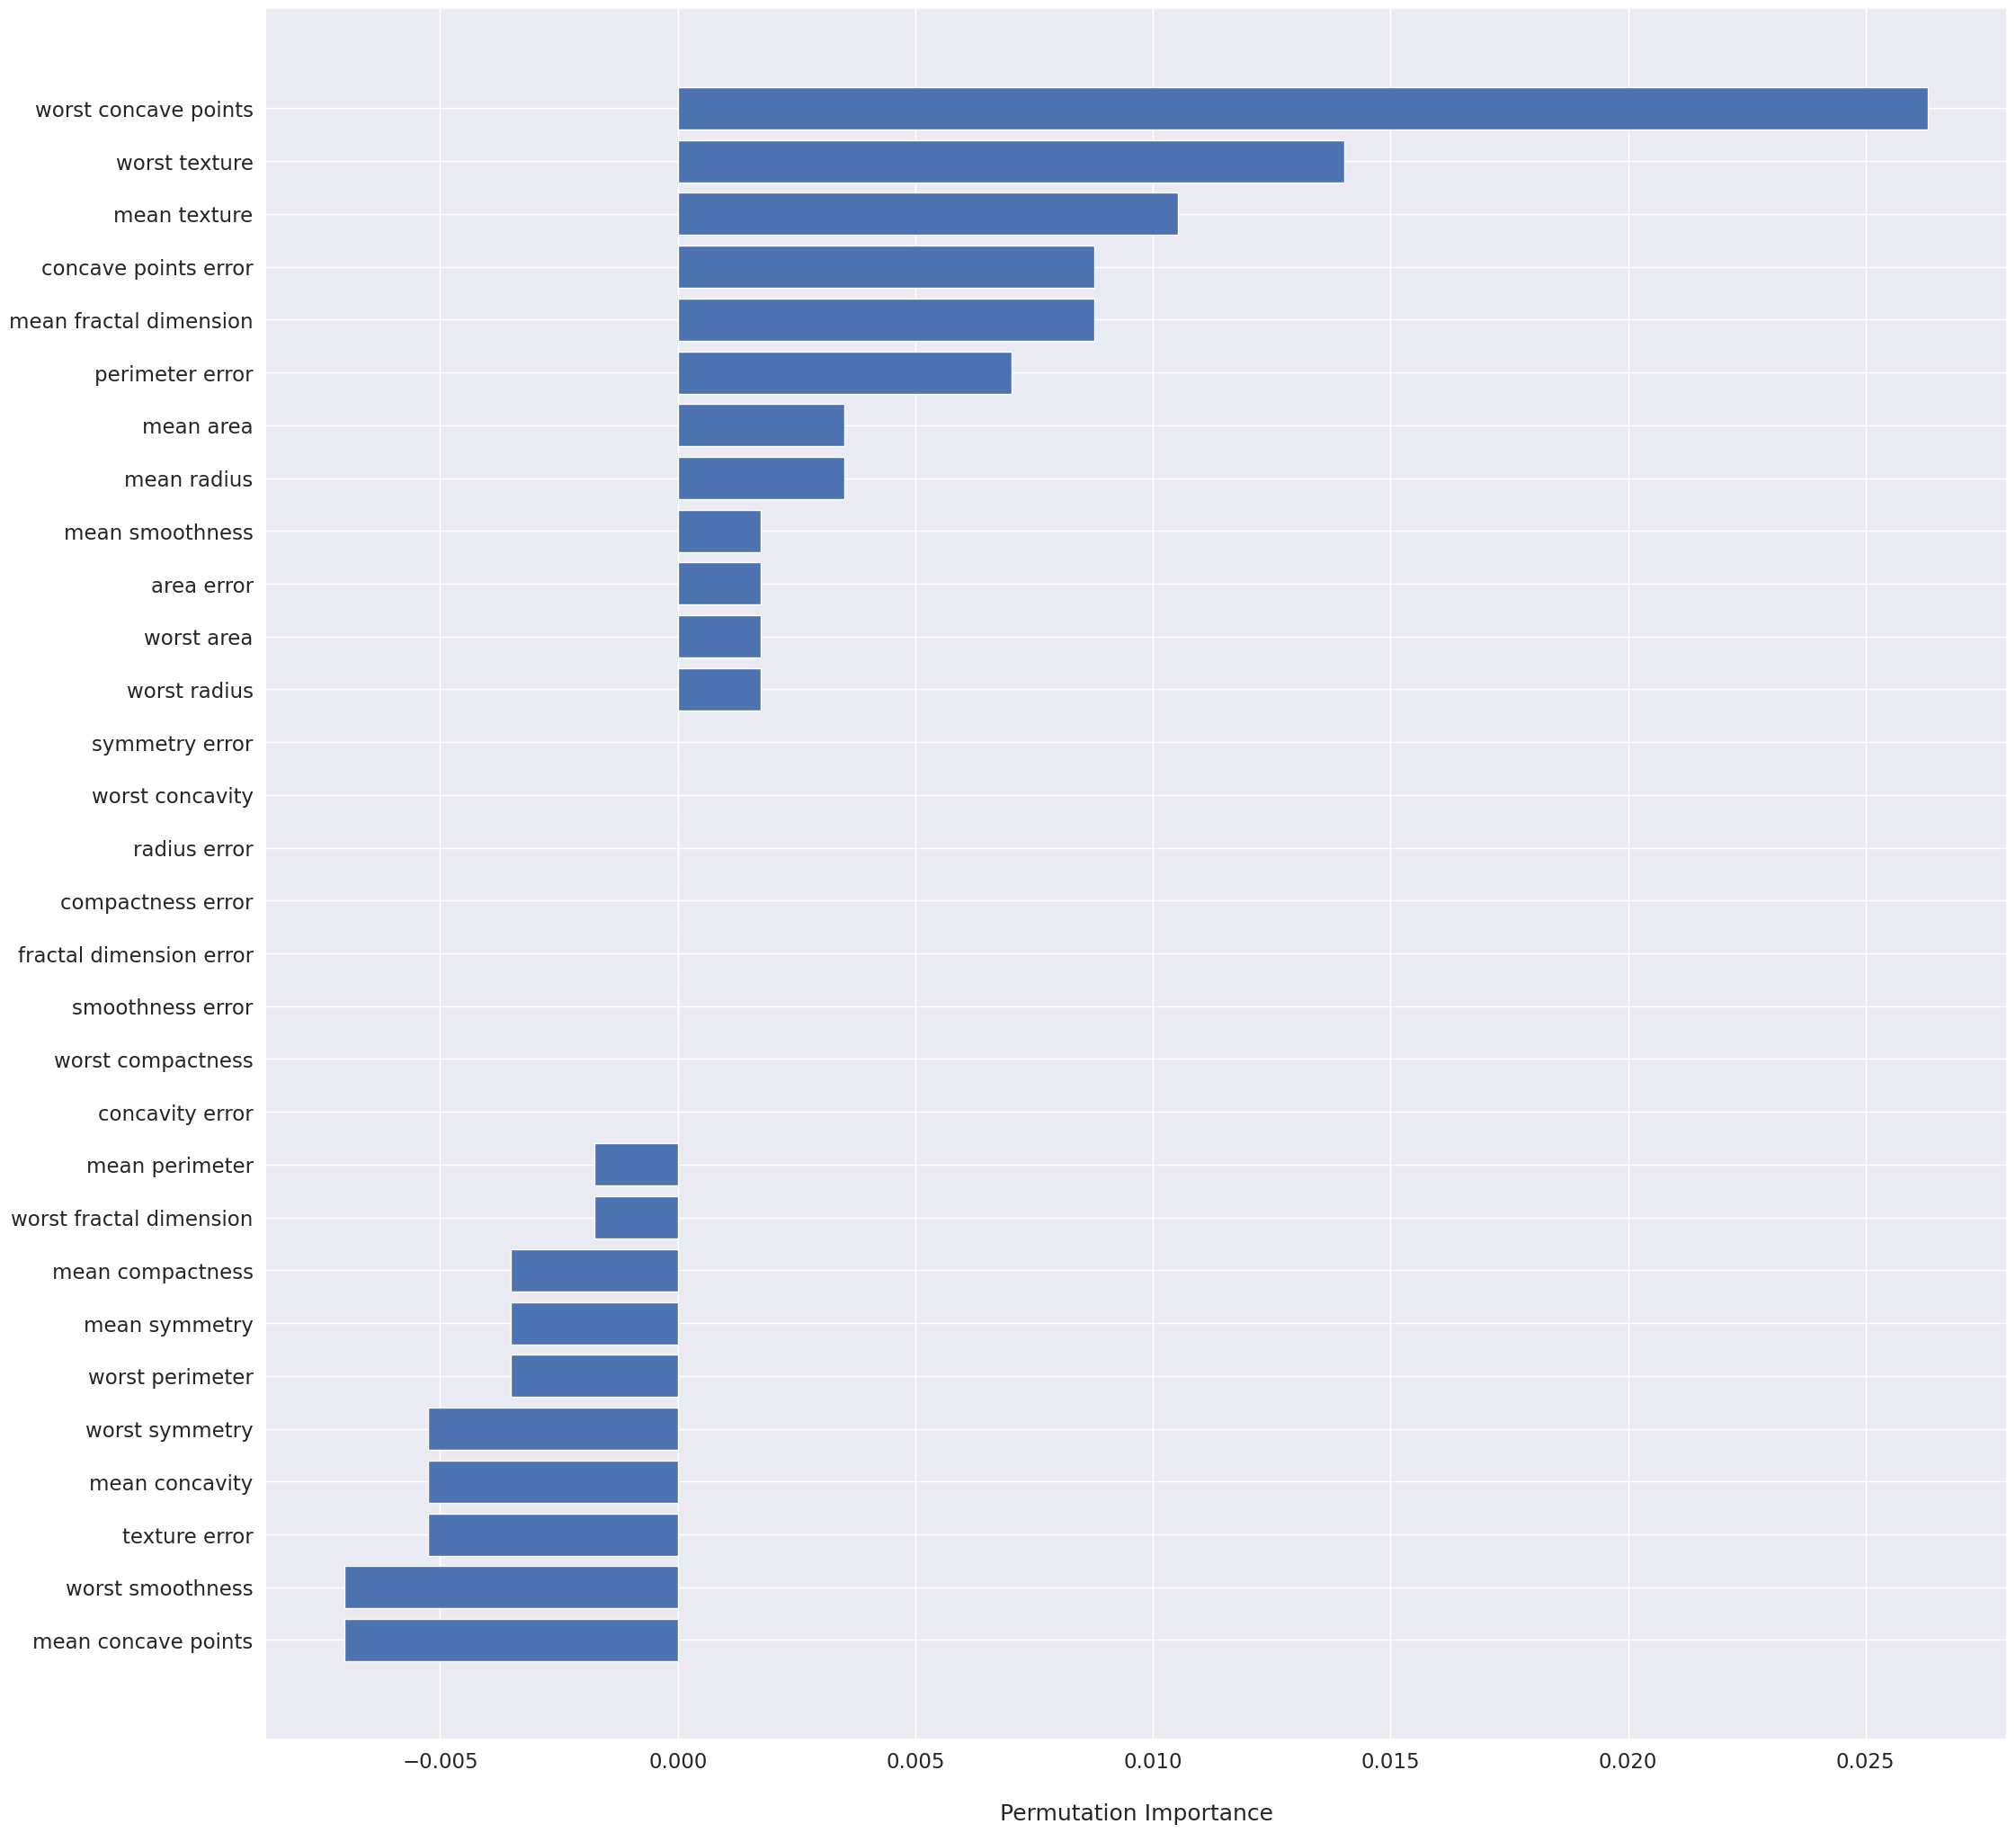

In [80]:
#Logistic Model
type_model='Regression Logistic'
processor_logistic = models_types(X=Xtrain,y=ytrain,Lista_variaveis=Lista_variaveis)
model= processor_logistic.logistic_model()
processor_logistic.metrics_class(model, Xtrain, ytrain, Xtest, ytest,type_model)


Model Accuracy: 98.25%

F1 Score: 98.24%

Confussion Matrix


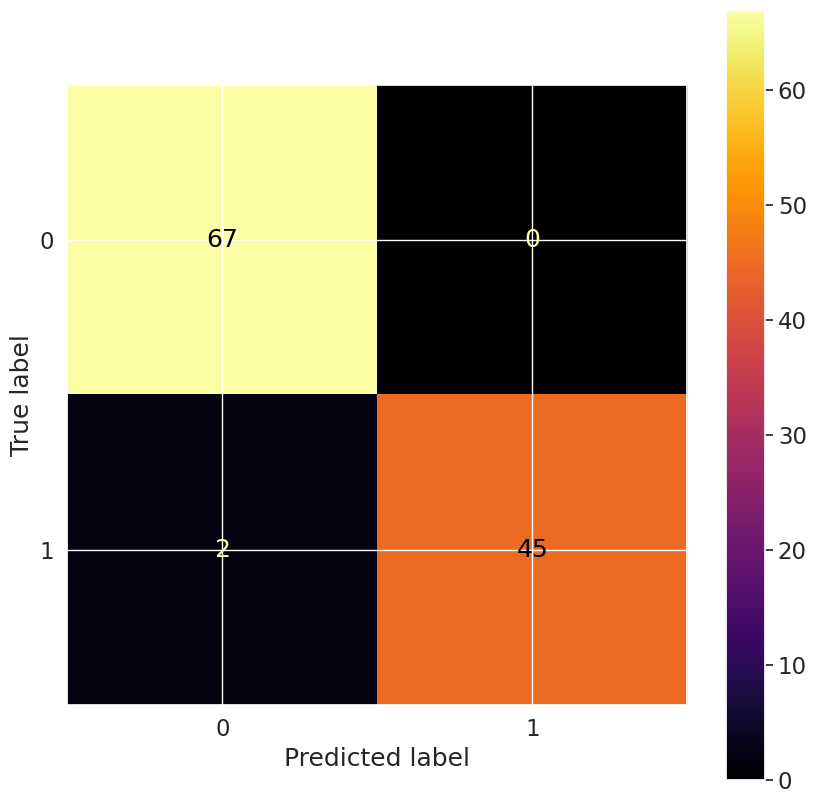


 Feature Importance


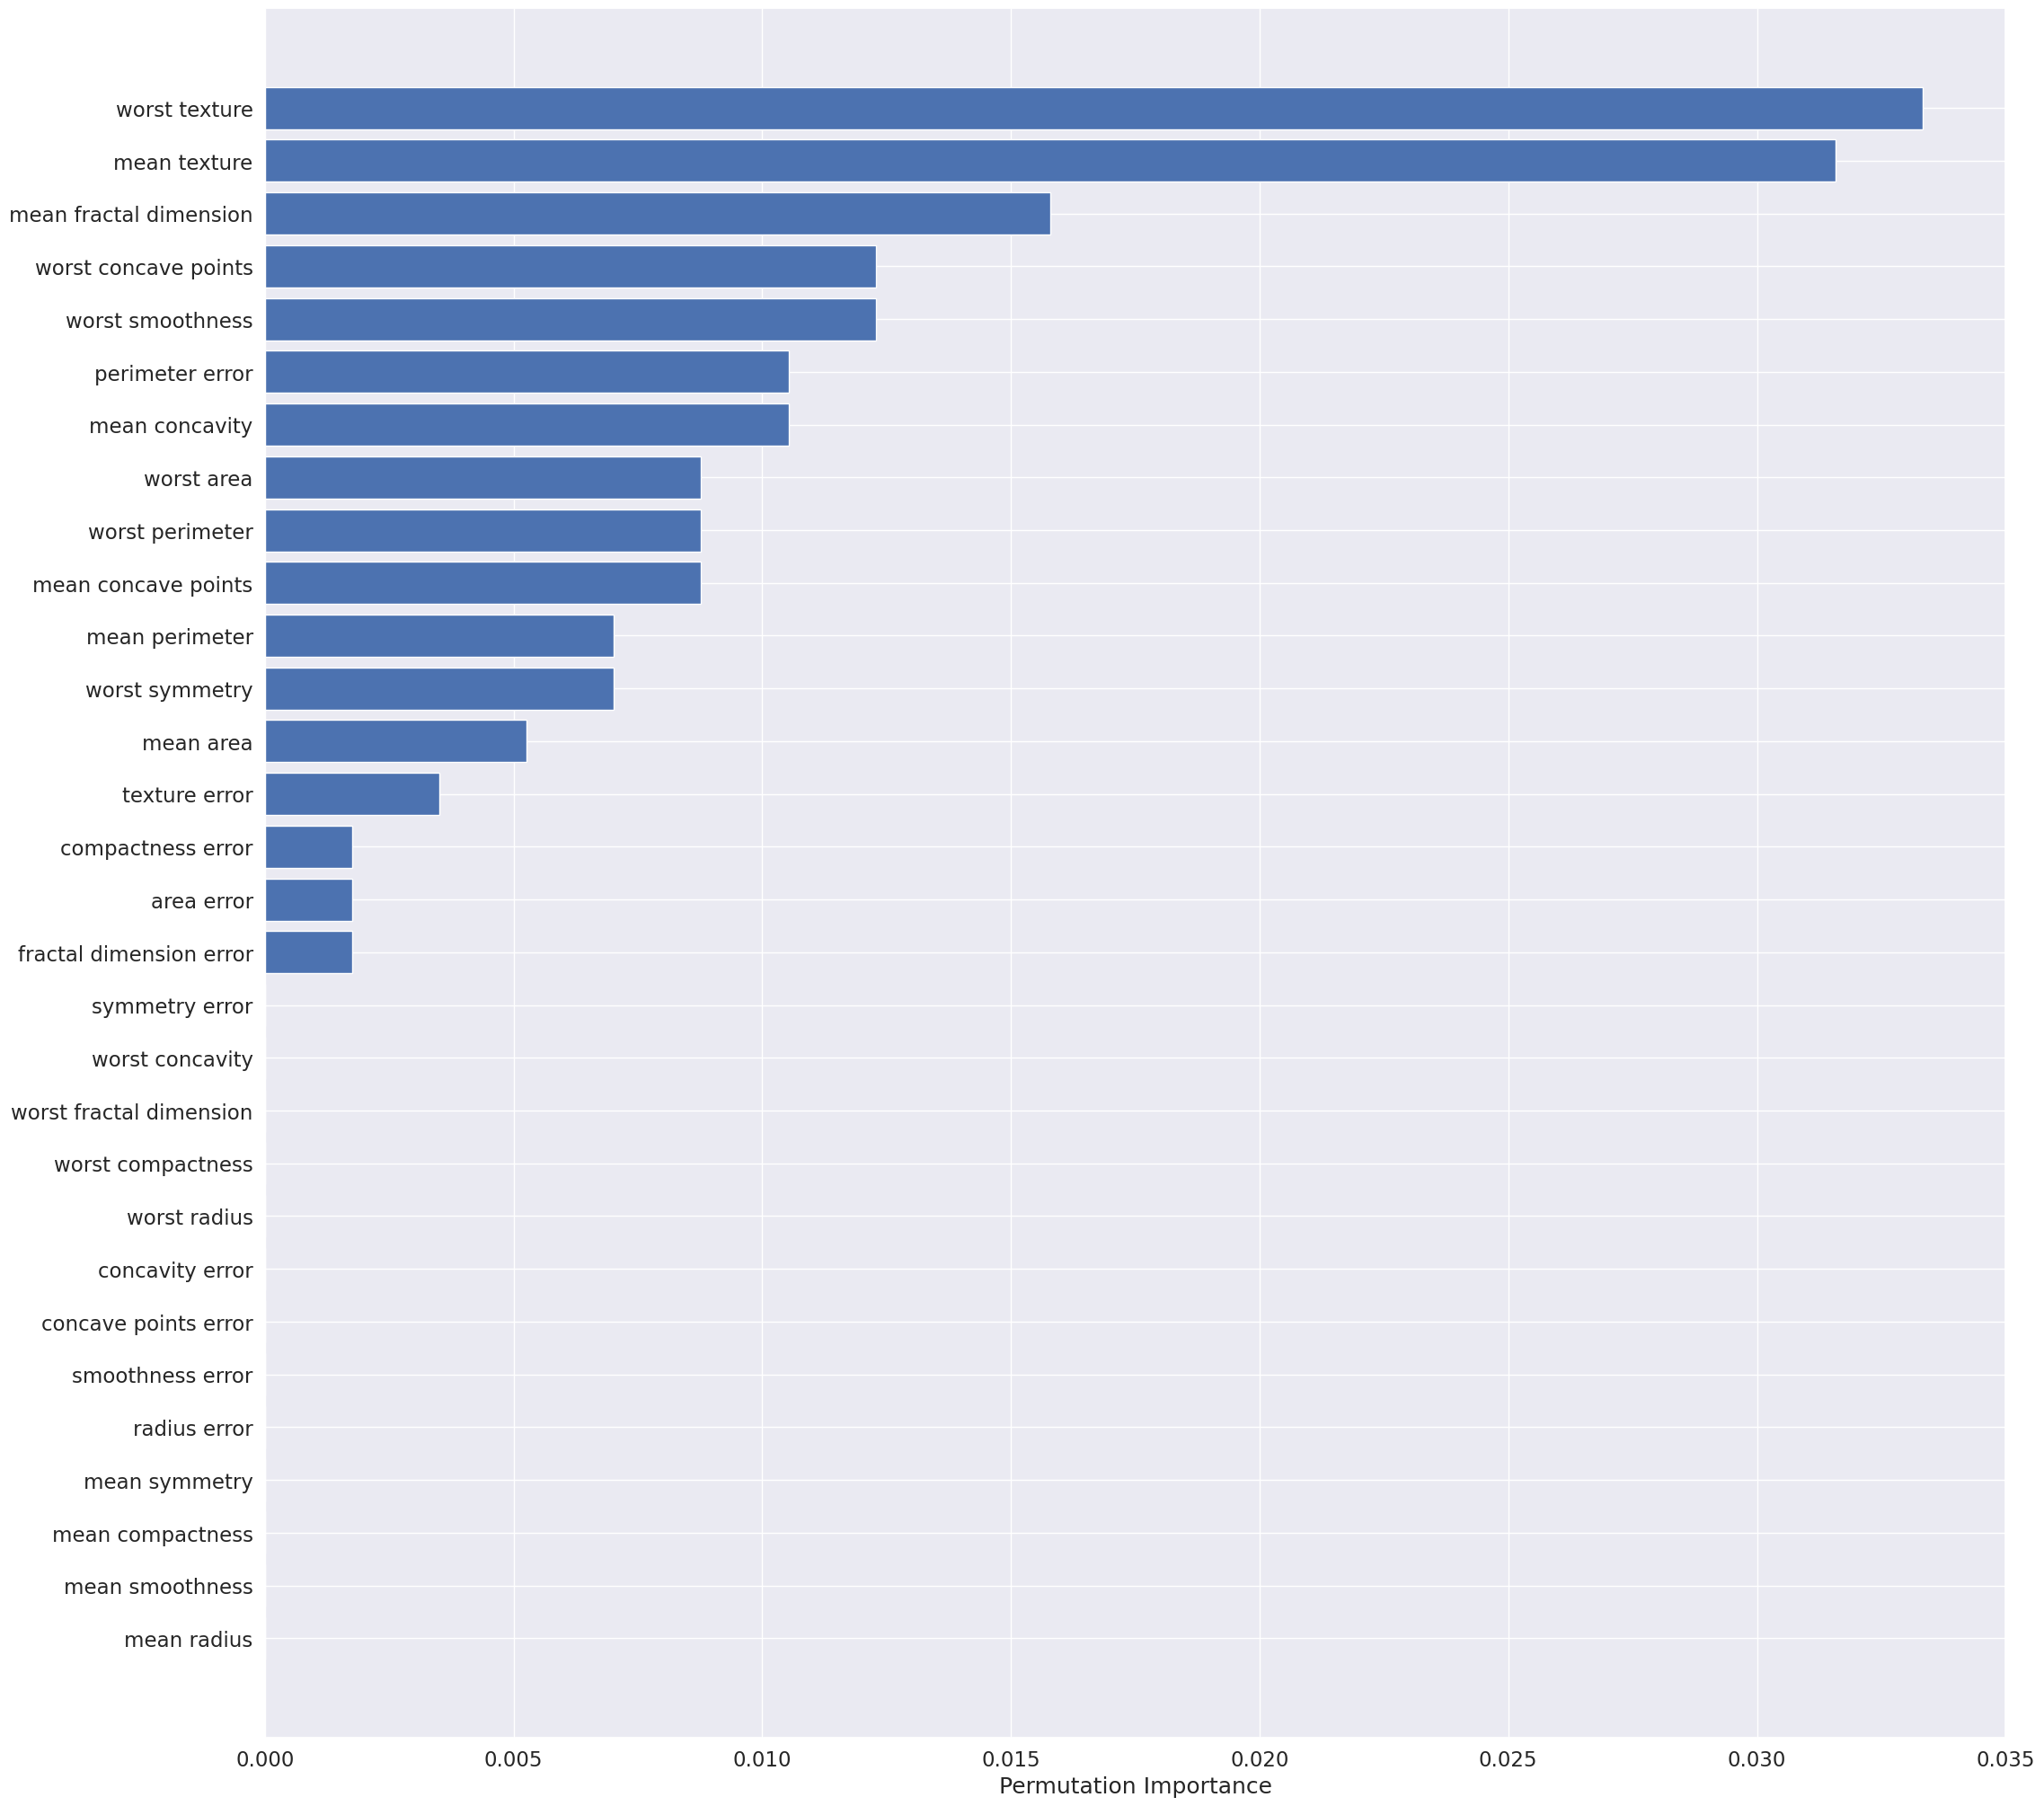

In [81]:
#SVM Model
type_model='SVM'
processor_svm = models_types(X=Xtrain,y=ytrain,Lista_variaveis=Lista_variaveis)
model= processor_svm.svm_model()
processor_svm.metrics_class(model, Xtrain, ytrain, Xtest, ytest,type_model)


Best Parameters {'n_neighbors': 3, 'p': 2}

Model Accuracy: 94.74%

F1 Score: 94.70%

Confussion Matrix


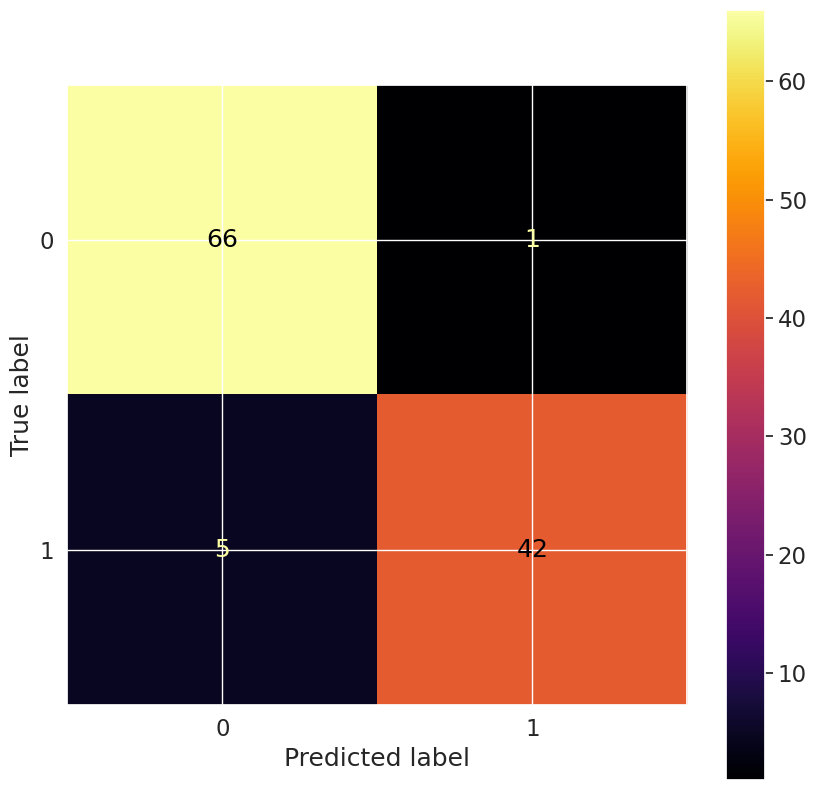


 KNN model does not have feature importance


In [82]:
#KNN Model
type_model='KNN'
processor_knn = models_types(X=Xtrain,y=ytrain,Lista_variaveis=Lista_variaveis)
model= processor_knn.knn_model()
processor_knn.metrics_class(model, Xtrain, ytrain, Xtest, ytest,type_model)

In [83]:
#PCA Method

#for k in range(2,len(Lista_variaveis)//2):
pca=PCA(n_components=3)
XTrain = pca.fit_transform(Xtrain)
XTest = pca.transform(Xtest)

processor_randomf = models_types(X=XTrain,y=ytrain,Lista_variaveis=Lista_variaveis,model_tree='Random Forest')
model= processor_randomf.tree_and_random_forest()
processor_randomf.models_metrics(model, XTrain, ytrain, XTest, ytest)
#processor_randomf.models_metrics_random_tree(model, XTrain, ytrain, XTest, ytest)


Best Parameters 20 5

 KS Validation: 71.43% e AUC: 98.29%

  (np.float64(0.9555275), np.float64(0.0))

  KS Development: 63.41% e AUC: 99.76%

 (np.float64(0.9909091), np.float64(0.0))


In [84]:
predition_1 = model.predict(XTest)
model_RandomForest_acc = accuracy_score(ytest, predition_1)
print("\nModel Accuracy: {:.2%}".format(model_RandomForest_acc))


Model Accuracy: 93.86%


In [85]:
pca=PCA(n_components=3)
pca.fit(XTest)
X_pca=pca.transform(XTest)
base=pd.DataFrame(data=X_pca,columns=['PC1','PC2','PC3'])
base['Cluster']=model.predict(XTest)
base
color_theme = np.array(['red','green'])


In [86]:
df = base
fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3',
              color=color_theme[base['Cluster']])
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [ ]:
y_pred=model.predict(X, verbose=0)
y_pred = [np.argmax(v) for v in y_pred]
X1 = processor.min_max_scaler.inverse_transform(X)
df = pd.DataFrame(data=X1, columns=Lista_variaveis)
df2 = pd.DataFrame(data=y,columns=['Tarq'])
df3 = pd.DataFrame(data=y_pred,columns=['Pred'])
df = pd.concat([df,df2,df3],axis=1)


In [ ]:
df.round(decimals=2).to_csv('df.csv',index=False)